# Problem: Selection Bias of GW Detector 

# Case 1(A): 

In [1]:
from pycbc.detector import Detector #Information of detectors
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform #Information of Waveform
from pycbc.waveform import td_approximants, fd_approximants
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import random
import numpy as np
import pycbc.psd
import pycbc.types
import astropy.cosmology as cosmo
from astropy import units

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
ra = 4.5
dec = 3.5
pol = 0.5
inc = 0
time = 10**12

In [2]:
#Generating Analytic PSD
delta_f = 1.0 / 4
flen = int(2048 / delta_f)
low_frequency_cutoff = 10.0

s = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, low_frequency_cutoff)
sf_interp = interpolate.interp1d(s.sample_frequencies.data, s.data)

In [3]:
chirp_mass_lower = 3
chirp_mass_upper = 1000
Number_of_sampels = 1000
chirp_mass_arr = np.random.uniform(chirp_mass_lower, chirp_mass_upper, Number_of_sampels)

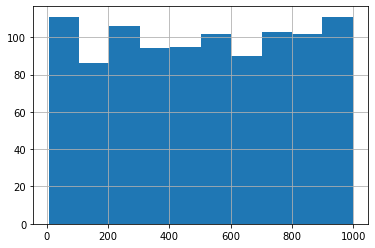

In [16]:
plt.hist(chirp_mass_arr)
plt.grid()

In [17]:
ra = 4.5
dec = 3.5
pol = 0.5
inc = 0
time = 10**12
eta = 0.24
snr_th = 8
distance = 400 # in units of Mpc
#q1 = 2.81
#q2 = 0.356
#H1 Detector
m1_arr = []
m2_arr = []
#SNR
rho_tot_arr = []
DH_arr = []
DZ_arr = []
rho1_arr = []
rho2_arr = []
rho3_arr = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")
fp1, fc1 = d1.antenna_pattern(ra, dec, pol, time)
fp2, fc2 = d2.antenna_pattern(ra, dec, pol, time)
fp3, fc3 = d3.antenna_pattern(ra, dec, pol, time)

# # call the psd and antenna patterns outside the for loop

for chirp_mass in chirp_mass_arr:
    
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    # functions require the values of mass1 and mass2
    m1, m2 = pycbc.pnutils.mchirp_eta_to_mass1_mass2(chirp_mass, eta)

    m1_arr.append(m1)
    m2_arr.append(m2)
    
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z= 0.9, 
                               spin2z = 0.9,
                             f_final = 1024,
                            inclination=inc,
                              distance=distance)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1 = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2 = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3 = np.trapz(snr_sq_integrand3, f_arr1)
    rho1 = np.sqrt(rho_sq1)
    rho2 = np.sqrt(rho_sq2)
    rho3 = np.sqrt(rho_sq3)
    rho_tot = np.sqrt(rho_sq1+rho_sq2+rho_sq3)
    rho_tot_arr.append(rho_tot)
    d=(rho_tot*distance/snr_th)
    DH_arr.append(d)
    rho1_arr.append(rho1)
    rho2_arr.append(rho2)
    rho3_arr.append(rho3)
    # save the snr for every detector here

In [18]:
DZ_arr = cosmo.z_at_value(cosmo.Planck15.luminosity_distance, DH_arr*units.Mpc)

In [ ]:
plt.figure(figsize=(8, 6))
plt.loglog(chirp_mass_arr, DZ_arr, '.')
plt.xlabel(r"$\mathcal{M}[M_{\odot}]$", fontsize=15)
plt.ylabel(r"$z$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("aLIGO sensivities, $\eta = 0.24, \iota = 0 $deg.")
plt.ylim(0.02, 5)
plt.grid()
plt.savefig("Redshift_vs_Chirp_Mass_with_fixed_eta_and_other_binary_params (Chirp_Mass Upper limit =1000.pdf")

Text(0.5, 1.0, 'aLIGO sensivities, $\\eta = 0.24, \\iota = 0 $deg.')

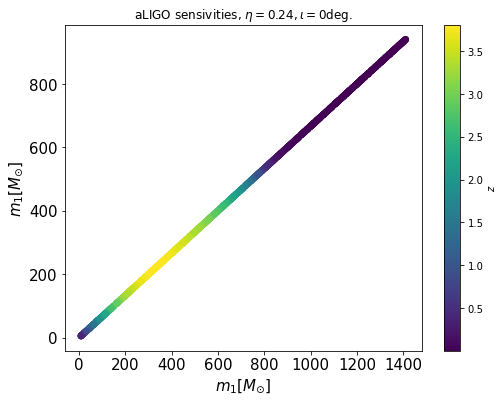

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(m1_arr, m2_arr, c=DZ_arr)
plt.xlabel(r"$m_1[M_{\odot}]$", fontsize=15)
plt.ylabel(r"$m_1[M_{\odot}]$", fontsize=15)
plt.colorbar(label=r"$z$")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("aLIGO sensivities, $\eta = 0.24, \iota = 0 $deg.")
#plt.ylim(0.02, 5)
#plt.grid()

In [ ]:
# data = dict()
# data["chirp_mass"] = chirp_mass_arr
# data["SNR_H1"] = rho1_arr
# data["SNR_L1"] = rho2_arr
# data["SNR_V1"] = rho3_arr

# data["horizon_distance_redshift"] = DZ_arr

# df = pd.DataFrame(data)
# df.to_csv("Redshift_vs_Chirp_Mass_with_fixed_eta_and_other_binary_params.dat", sep=" ", index=False)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(chirp_mass_arr, rho_tot_arr,".")
plt.xlabel("Chirp Mass (M_c)")
plt.ylabel("SNR (\u03C1)")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"Chirp Mass ($M_c$)", fontsize=15)
plt.ylabel(r"$\rho_{\mathrm{net}}$", fontsize=15)
image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'network_snr_vs_chirp_mass_with_fixed_eta_and_other_binary_params.pdf'
plt.savefig(image_name, format=image_format, dpi=400)

In [ ]:
# rho1 = pd.DataFrame(rho1)
# rho2 = pd.DataFrame(rho2)
# rho3 = pd.DataFrame(rho3)
# df1.to_csv(rho1.dat)
# df2.to_csv(rho2.dat)
# df3.to_csv(rho3.dat)

In [ ]:
plt.plot(chirp_mass_arr,DH_arr,".")

# Case 1(B): Varying eta with the  fixed chirp-mass

In [41]:
chirp_mass = 43.52
eta_lower = 0.02
eta_upper = 0.25
Number_of_sampels = 1000
eta_arr = np.random.uniform(eta_lower, eta_upper, Number_of_sampels)

In [ ]:
plt.hist(eta_arr)
plt.grid()

In [42]:
ra = 4.5
dec = 3.5
pol = 0.5
inc = 0
time = 10**12
snr_th = 8
distance = 400 # in units of Mpc
#H1 Detector
m1_arr = []
m2_arr = []

#SNR
DH1_arr = []
DZ1_arr = []
rho1_arr =[]
rho2_arr =[]
rho3_arr =[]
rho_tot_arr = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")
fp1, fc1 = d1.antenna_pattern(ra, dec, pol, time)
fp2, fc2 = d2.antenna_pattern(ra, dec, pol, time)
fp3, fc3 = d3.antenna_pattern(ra, dec, pol, time)

# # call the psd and antenna patterns outside the for loop

for eta in eta_arr:
    
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    # functions require the values of mass1 and mass2
    m1, m2 = pycbc.pnutils.mchirp_eta_to_mass1_mass2(chirp_mass, eta)

    m1_arr.append(m1)
    m2_arr.append(m2)
    #print("m1 = %f, m2 = %f"%(m1, m2))
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2, f_lower=20, delta_f=0.01, 
                             f_final = 1024,
                            inclination=inc,
                              distance=400)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)

    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1 = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2 = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3 = np.trapz(snr_sq_integrand3, f_arr1)
    
    rho_tot = np.sqrt(rho_sq1+rho_sq2+rho_sq3)
    rho_tot_arr.append(rho_tot)
    d=(rho_tot*distance/snr_th)
    DH1_arr.append(d)
    rho1_arr.append(np.sqrt(rho_sq1))
    rho2_arr.append(np.sqrt(rho_sq2))
    rho3_arr.append(np.sqrt(rho_sq3))
    # save the snr for every detector here

In [44]:
DZ1_arr = cosmo.z_at_value(cosmo.Planck15.luminosity_distance, DH1_arr*units.Mpc)

In [ ]:
plt.plot(eta_arr,DZ1_arr)

In [ ]:
# data = dict()
# data["eta"] = eta_arr
# data["SNR_H1"] = rho1_arr
# data["SNR_L1"] = rho2_arr
# data["SNR_V1"] = rho3_arr

# data["horizon_distance_redshift"] = DZ1_arr

# df = pd.DataFrame(data)
# df.to_csv("Redshift_vs_eta_with_fixed_chirp_mass_and_other_binary_params.dat", sep=" ", index=False)

In [33]:
df = pd.read_csv("Redshift_vs_eta_with_fixed_chirp_mass_and_other_binary_params.dat")
df

,eta SNR_H1 SNR_L1 SNR_V1 horizon_distance_redshift
0,0.04735023998734236 34.93144798370275 27.08375...
1,0.2327999694034499 114.90508588247319 89.09054...
2,0.07585636218484458 54.04583162334149 41.90390...
3,0.1746033714769672 97.45155332043778 75.558113...
4,0.17304876601703056 96.939235354677 75.1608927...
...,...
995,0.17025872738338768 96.01055487992544 74.44084...
996,0.05025975046693218 36.961750522648934 28.6579...
997,0.11933096585150092 76.41665980707042 59.24891...
998,0.20406840724585482 106.61076573178646 82.6596...


ValueError: Illegal format string "horizon_distance_redshift"; two marker symbols

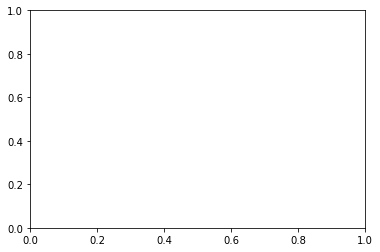

In [38]:
plt.plot("eta","horizon_distance_redshift", data=df)

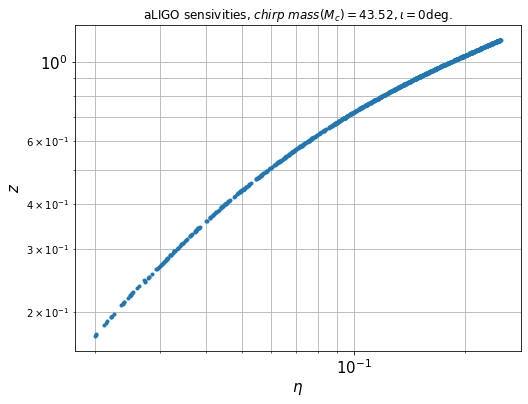

In [56]:
plt.figure(figsize=(8, 6))
plt.loglog(eta_arr, DZ1_arr,".")
plt.xlabel(r"$\eta$", fontsize=15)
plt.ylabel(r"$z$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("aLIGO sensivities, $chirp\ mass (M_{c}) = 43.52, \iota = 0 $deg.")
image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'Redshift_vs_eta_with_fixed_chirp_mass_and_other_binary_params.pdf'
plt.grid(which="both")
plt.savefig(image_name, format=image_format, dpi=400)


In [ ]:
rho_tot

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(eta_arr, rho_tot_arr, '.')
plt.xlabel(r"$\eta$", fontsize=15)
plt.ylabel(r"$\rho_{\mathrm{net}}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("network_snr_vs_eta_with_fixed_chirp_mass_and_other_binary_params.pdf")

In [ ]:
plt.figure(figsize=(10, 7))
plt.semilogy(eta_arr, rho_tot_arr, '.')
plt.xlabel(r"$\eta$", fontsize=15)
plt.ylabel(r"$\rho_{\mathrm{net}}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Case 1(C): Considering the Spin Effect

In [4]:
spin1z_lower = spin2z_lower = -0.99
spin1z_upper = spin2z_upper= 0.99
Number_of_sampels = 10000
spin1z_arr = np.random.uniform(spin1z_lower, spin1z_upper, Number_of_sampels)
spin2z_arr = np.random.uniform(spin2z_lower, spin2z_upper, Number_of_sampels)

In [5]:
len(spin2z_arr)

10000

In [6]:
ra = 4.5
dec = 3.5
pol = 0.5
inc = 0
time = 10**12
eta = 0.24
snr_th = 8
distance = 400 # in units of Mpc
chirp_mass = 26.11
#q1 = 2.81
#q2 = 0.356
#H1 Detector
m1_arr = []
m2_arr = []
#SNR
rho_tot_arr = []
DH_arr = []
DZ_arr = []
rho1_arr = []
rho2_arr = []
rho3_arr = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")
fp1, fc1 = d1.antenna_pattern(ra, dec, pol, time)
fp2, fc2 = d2.antenna_pattern(ra, dec, pol, time)
fp3, fc3 = d3.antenna_pattern(ra, dec, pol, time)

# # call the psd and antenna patterns outside the for loop

for s1z, s2z in zip(spin1z_arr, spin2z_arr):
    
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    # functions require the values of mass1 and mass2
    m1, m2 = pycbc.pnutils.mchirp_eta_to_mass1_mass2(chirp_mass, eta)

    m1_arr.append(m1)
    m2_arr.append(m2)
    
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z=s1z, 
                               spin2z=s2z,
                             f_final = 1024,
                            inclination=inc,
                              distance=distance)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1 = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2 = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3 = np.trapz(snr_sq_integrand3, f_arr1)
    rho1 = np.sqrt(rho_sq1)
    rho2 = np.sqrt(rho_sq2)
    rho3 = np.sqrt(rho_sq3)
    rho_tot = np.sqrt(rho_sq1+rho_sq2+rho_sq3)
    rho_tot_arr.append(rho_tot)
    d=(rho_tot*distance/snr_th)
    DZ_arr.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, d*units.Mpc))
    rho1_arr.append(rho1)
    rho2_arr.append(rho2)
    rho3_arr.append(rho3)
    # save the snr for every detector here

In [ ]:
#DZ_arr = cosmo.z_at_value(cosmo.Planck15.luminosity_distance, DH_arr*units.Mpc)

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(spin2z_arr, DZ_arr,".")
# plt.xlabel(r"$spin2z$", fontsize=15)
# plt.ylabel(r"$z$", fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# #plt.title("aLIGO sensivities, $chirp mass (M_{c}) = 43.52, \iota = 0 $deg.")
# # image_format = 'pdf' # e.g .png, .svg, etc.
# # image_name = 'Redshift_vs_eta_with_fixed_chirp_mass_and_other_binary_params.pdf'
# # plt.savefig(image_name, format=image_format, dpi=400)
# plt.savefig("redshift vs spin 2z.pdf")
# plt.grid()

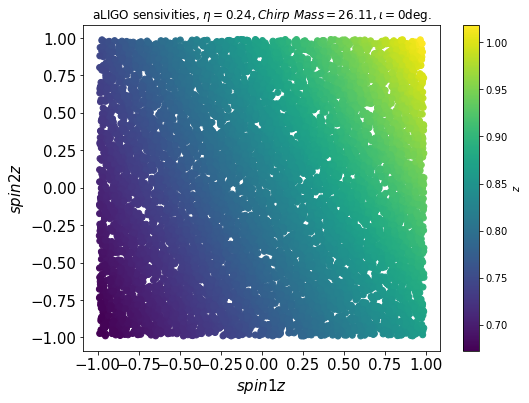

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(spin1z_arr, spin2z_arr, c=DZ_arr)
plt.xlabel(r"$spin1z$", fontsize=15)
plt.ylabel(r"$spin2z$", fontsize=15)
plt.colorbar(label=r"$z$")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("aLIGO sensivities, $\eta = 0.24, Chirp\ Mass = 26.11, \iota = 0 $deg.")
plt.savefig("Horizon_Distance_function_of_spin1z-spin2z.pdf")
#plt.ylim(24.5, 24.9)
#plt.xlim(36.86, 36.9)

# Case 1(D): Variation in Mass m1 and q

In [19]:
m1_lower = 5
m1_upper = 1000
q_lower = 0.05
q_upper = 1
Number_of_sampels = 10000
m1_arr = np.random.uniform(m1_lower, m1_upper, Number_of_sampels)
q_arr = np.random.uniform(q_lower, q_upper, Number_of_sampels)

In [20]:
ra = 4.5
dec = 3.5
pol = 0.5
inc = 0
time = 10**12
chirp_mass = 26.11
eta=0.24
snr_th = 8
distance = 400 # in units of Mpc
#q1 = 2.81
#q2 = 0.356
#H1 Detector
#m1_arr = []
m2_arr = []
#SNR
rho_tot_arr = []
DH_arr = []
DZ_arr = []
rho1_arr = []
rho2_arr = []
rho3_arr = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")
fp1, fc1 = d1.antenna_pattern(ra, dec, pol, time)
fp2, fc2 = d2.antenna_pattern(ra, dec, pol, time)
fp3, fc3 = d3.antenna_pattern(ra, dec, pol, time)

# # call the psd and antenna patterns outside the for loop

for m1, q in zip(m1_arr, q_arr):
    
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    # functions require the values of mass1 and mass2
    m2 = m1*q
    m2_arr.append(m2)
    
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,
                             f_final = 1024,
                            inclination=inc,
                              distance=distance)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1 = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2 = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3 = np.trapz(snr_sq_integrand3, f_arr1)
    rho1 = np.sqrt(rho_sq1)
    rho2 = np.sqrt(rho_sq2)
    rho3 = np.sqrt(rho_sq3)
    rho_tot = np.sqrt(rho_sq1+rho_sq2+rho_sq3)
    rho_tot_arr.append(rho_tot)
    d=(rho_tot*distance/snr_th)
    DZ_arr.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, d*units.Mpc))
    rho1_arr.append(rho1)
    rho2_arr.append(rho2)
    rho3_arr.append(rho3)
    # save the snr for every detector here

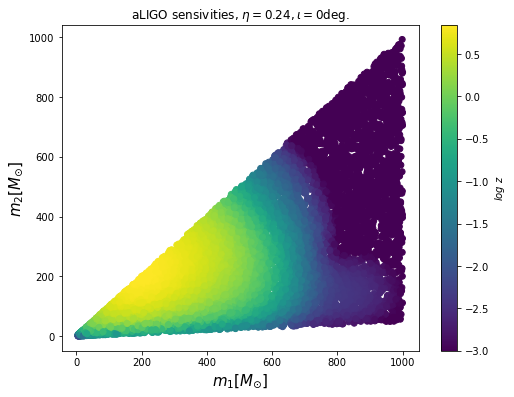

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(m1_arr, m2_arr, c=np.log(DZ_arr))
plt.xlabel(r"$m_1[M_{\odot}]$", fontsize=15)
plt.ylabel(r"$m_2[M_{\odot}]$", fontsize=15)
plt.colorbar(label=r"$log\ z$")
plt.title("aLIGO sensivities, $\eta = 0.24, \iota = 0 $deg.")
plt.clim(-3,None)
plt.savefig("selection_effects_with_mass_m1_and_mass_ratio_q.pdf")

In [ ]:
plt.hist(rho_tot_arr)

In [ ]:
min(rho_tot_arr)

In [11]:
m1_arr = np.array(m1_arr)
m2_arr = np.array(m2_arr)
DZ_arr = np.array(DZ_arr)
rho_tot_arr = np.array(rho_tot_arr)
snr_th_idx = rho_tot_arr >= 8

Text(0.5, 1.0, 'aLIGO sensivities, $m_1 \\in [5, 1000] m_{\\odot}, q\\in [0.05, 1]\\iota = 0 $deg.')

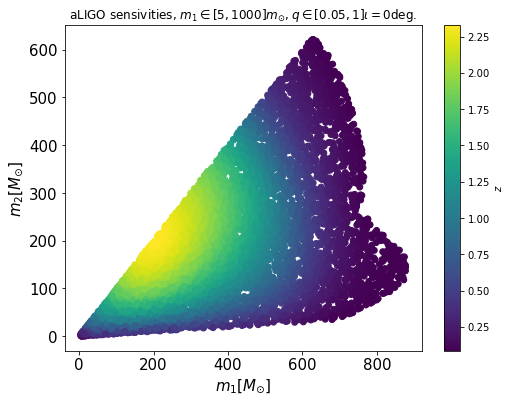

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(m1_arr[snr_th_idx], m2_arr[snr_th_idx], c=DZ_arr[snr_th_idx])
plt.xlabel(r"$m_1[M_{\odot}]$", fontsize=15)
plt.ylabel(r"$m_2[M_{\odot}]$", fontsize=15)
plt.colorbar(label=r"$z$")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("aLIGO sensivities, $m_1 \in [5, 1000] m_{\odot}, q\in [0.05, 1]\iota = 0 $deg.")
#plt.ylim(0.02, 5)

Text(0.5, 1.0, 'aLIGO sensivities, $m_1 \\in [5, 1000] M_{\\odot}, q\\in [0.05, 1],\\iota = 0 $deg.')

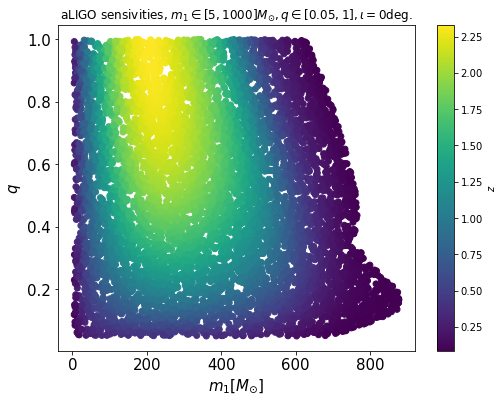

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(m1_arr[snr_th_idx], m2_arr[snr_th_idx]/m1_arr[snr_th_idx], c=DZ_arr[snr_th_idx])
plt.xlabel(r"$m_1[M_{\odot}]$", fontsize=15)
plt.ylabel(r"$q$", fontsize=15)
plt.colorbar(label=r"$z$")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("aLIGO sensivities, $m_1 \in [5, 1000] M_{\odot}, q\in [0.05, 1],\iota = 0 $deg.")
#plt.ylim(0.02, 5)

# Case 2(A) : Understanding selection effects with multiple factors

In [88]:
# m1_lower = 5
# m1_upper = 500
# q_lower = 0.05
# q_upper = 1
# dec_lower = -1.5707963267948966
# dec_upper = 1.5707963267948966
# ra_lower = 0
# ra_upper = 6.283185307179586
# theta_lower = -1
# theta_upper = 1
# psi_lower = 0
# psi_upper = 3.141592653589793
# spin1z_lower = 0
# spin1z_upper = 0.99
# spin2z_lower = 0
# spin2z_upper = 0.99
# geocent_time = 1126259460.0
# luminosity_distance_lower = 1
# luminosity_distance_upper = 30000
# Number_of_sampels = 20000
# m1_arr = np.random.uniform(m1_lower, m1_upper, Number_of_sampels)
# q_arr = np.random.uniform(q_lower, q_upper, Number_of_sampels)
# dec_arr = np.random.uniform(dec_lower, dec_upper, Number_of_sampels)
# ra_arr = np.random.uniform(ra_lower, ra_upper, Number_of_sampels)
# theta_arr = np.random.uniform(theta_lower, theta_upper, Number_of_sampels)
# spin1z_arr = np.random.uniform(spin1z_lower, spin1z_upper, Number_of_sampels)
# spin2z_arr = np.random.uniform(spin2z_lower, spin2z_upper, Number_of_sampels)
# luminosity_distance_arr = np.random.uniform(luminosity_distance_lower, luminosity_distance_upper, Number_of_sampels)
# psi_arr = np.random.uniform(psi_lower, psi_upper, Number_of_sampels)

In [6]:
data = pd.read_csv("/home/aruna/Downloads/ICTS-TIFR/scripts/injections/injection_file_m1_log_uniform_q_inverse_sqaure_dL_USF_spins_uniform_magnitude.dat")

In [7]:
data

,mass_1 mass_ratio dec ra cos_theta_jn psi phase a_1 a_2 tilt_1 tilt_2 phi_12 phi_jl luminosity_distance geocent_time
0,160.65635805611095 0.14750691326625917 1.07497...
1,146.61821277113202 0.10456218617189442 -0.3601...
2,61.47754326144678 0.10433375804964894 -0.30109...
3,33.1879087260402 0.18651788804736175 0.4652696...
4,16.824627984459852 0.4903809853872023 0.591214...
...,...
19995,193.54726452831937 0.10559992152127612 -0.6667...
19996,57.614253903796666 0.15963835415926078 0.53816...
19997,131.95271293625274 0.18812621128216414 0.88761...
19998,200.3100232840373 0.10414261603384571 -0.02646...


In [6]:
get_fd_waveform?

In [8]:
snr_th = 8
geocent_time = 1126259460.0
m2_arr = []
m1_arr = []
q_arr = []
s1z_arr = []
s2z_arr = []
luminosity_distance_arr = []
#SNR
rho_tot_arr = []
DH_arr = []
DZ_arr = []
rho1_arr = []
rho2_arr = []
rho3_arr = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")


# # call the psd and antenna patterns outside the for loop

for m1, q, dec, ra, cos_theta, psi, s1z, s2z, luminosity_distance in zip(data["mass_1"], data["mass_ratio"], data["dec"], data["ra"], data["cos_theta_jn"], data["psi"], data["a_1"], data["a_2"], data["luminosity_distance"]):
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    #functions require the values of mass1 and mass2
    m2 = m1*q
    m2_arr.append(m2)
    m1_arr.append(m1)
    q_arr.append(q)
    s1z_arr.append(s1z)
    s2z_arr.append(s2z)
    luminosity_distance_arr.append(luminosity_distance)
    print("luminosity_distance = %f"%(luminosity_distance))
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z=s1z,  
                               psi=psi,
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance)
    
    #Antenna patterns
    fp1, fc1 = d1.antenna_pattern(ra, dec, psi, geocent_time)
    fp2, fc2 = d2.antenna_pattern(ra, dec, psi, geocent_time)
    fp3, fc3 = d3.antenna_pattern(ra, dec, psi, geocent_time)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1 = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2 = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3 = np.trapz(snr_sq_integrand3, f_arr1)
    rho1 = np.sqrt(rho_sq1)
    rho2 = np.sqrt(rho_sq2)
    rho3 = np.sqrt(rho_sq3)
    rho_tot = np.sqrt(rho_sq1+rho_sq2+rho_sq3)
    rho_tot_arr.append(rho_tot)
    d=(rho_tot*luminosity_distance/snr_th)
    DZ_arr.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, d*units.Mpc))
    rho1_arr.append(rho1)
    rho2_arr.append(rho2)
    rho3_arr.append(rho3)
    # save the snr for every detector here

KeyError: 'mass_1'

In [19]:
get_fd_waveform?

In [38]:
cosmo.z_at_value(cosmo.Planck15.luminosity_distance,d*units.Mpc)

<Quantity 0.08500207 redshift>

In [94]:
d=(rho_tot*luminosity_distance/snr_th)
d

4574.186557610905

In [95]:
DH_arr.append(d)

In [128]:
m1

197.3810705903557

In [14]:
m1_arr = np.array(m1_arr)
m2_arr = np.array(m2_arr)
DZ_arr = np.array(DZ_arr)
q_arr = np.array(q_arr)
luminosity_distance_arr = np.array(luminosity_distance_arr)
rho_tot_arr = np.array(rho_tot_arr)
snr_th_idx = rho_tot_arr >= 8
m1_arr_det = m1_arr[snr_th_idx]
m2_arr_det = m2_arr[snr_th_idx]

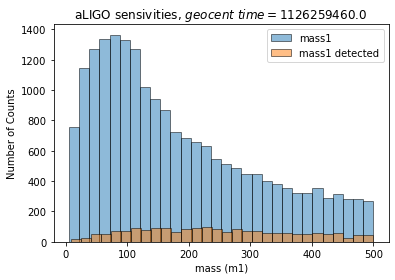

In [72]:
plt.hist(m1_arr,bins=30, alpha=0.5,label='mass1',edgecolor='black')
plt.hist(m1_arr_det,bins=30, alpha=0.5,label='mass1 detected',edgecolor='black')
plt.legend(loc='upper right')
plt.title("aLIGO sensivities, $geocent\ time =1126259460.0.$")
plt.xlabel("mass (m1)")
plt.ylabel("Number of Counts")
plt.savefig("Histogram.pdf")

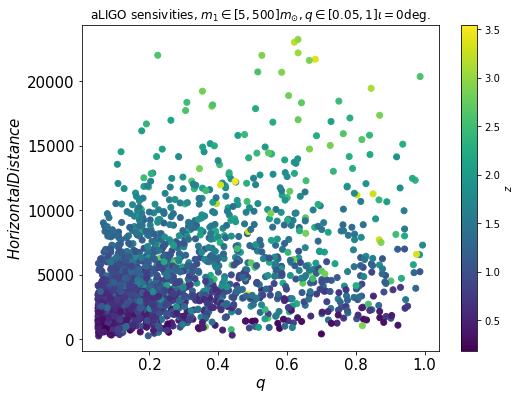

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(q_arr[snr_th_idx], luminosity_distance_arr[snr_th_idx], c=DZ_arr[snr_th_idx])
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$Horizontal Distance$", fontsize=15)
plt.colorbar(label=r"$z$")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("aLIGO sensivities, $m_1 \in [5, 500] m_{\odot}, q\in [0.05, 1]\iota = 0 $deg.")
#plt.ylim(0.02, 5)
plt.savefig("selection_effects_with_Horizontal_Distance_and_mass_ratio_q.pdf")

Text(0.5, 1.0, 'aLIGO sensivities, $m_1 \\in [5, 500] m_{\\odot}, q\\in [0.05, 1]\\iota = 0 $deg.')

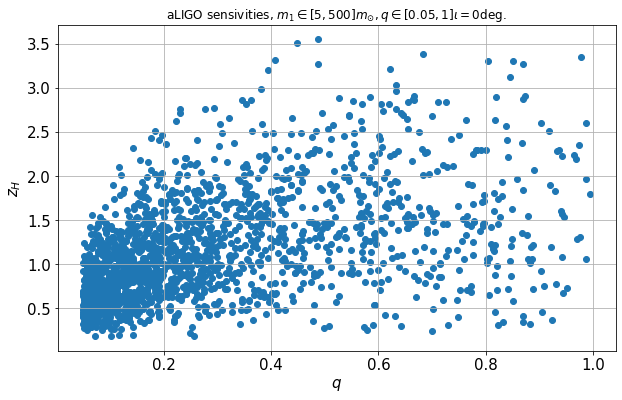

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(q_arr[snr_th_idx], DZ_arr[snr_th_idx])
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$z_{H}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.title("aLIGO sensivities, $m_1 \in [5, 500] m_{\odot}, q\in [0.05, 1]\iota = 0 $deg.")
#plt.ylim(0.02, 5)

In [20]:
snr_th = 8
geocent_time = 1126259460.0
m2_arr = []
m1_arr = []
q_arr = []
s1z_arr = []
s2z_arr = []
luminosity_distance_arr = []
#SNR
rho_tot_arrn = []
DH_arrn = []
DZ_arrn = []
rho1_arrn = []
rho2_arrn = []
rho3_arrn = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")


# # call the psd and antenna patterns outside the for loop

for m1, q, dec, ra, cos_theta, psi, s1z, s2z, luminosity_distance in zip(data["mass_1"], data["mass_ratio"], data["dec"], data["ra"], data["cos_theta_jn"], data["psi"], data["a_1"], data["a_2"], data["luminosity_distance"]):
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    #functions require the values of mass1 and mass2
    m2 = m1*q
    m2_arr.append(m2)
    m1_arr.append(m1)
    q_arr.append(q)
    s1z_arr.append(s1z)
    s2z_arr.append(s2z)
    luminosity_distance_arr.append(luminosity_distance)
    print("luminosity_distance = %f"%(luminosity_distance))
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z=s1z,  
                               psi=psi,
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance,
                              mode_array=[[2,2],[2, -2]])
    
    #Antenna patterns
    fp1, fc1 = d1.antenna_pattern(ra, dec, psi, geocent_time)
    fp2, fc2 = d2.antenna_pattern(ra, dec, psi, geocent_time)
    fp3, fc3 = d3.antenna_pattern(ra, dec, psi, geocent_time)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1n = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2n = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3n = np.trapz(snr_sq_integrand3, f_arr1)
    rho1n = np.sqrt(rho_sq1n)
    rho2n = np.sqrt(rho_sq2n)
    rho3n = np.sqrt(rho_sq3n)
    rho_totn = np.sqrt(rho_sq1n+rho_sq2n+rho_sq3n)
    rho_tot_arrn.append(rho_totn)
    dn=(rho_totn*luminosity_distance/snr_th)
    DZ_arrn.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, dn*units.Mpc))
    rho1_arrn.append(rho1n)
    rho2_arrn.append(rho2n)
    rho3_arrn.append(rho3n)
    # save the snr for every detector here

luminosity_distance = 7922.672898
luminosity_distance = 6186.075754
luminosity_distance = 22567.250036
luminosity_distance = 18973.778310
luminosity_distance = 20472.553537
luminosity_distance = 9511.044542
luminosity_distance = 14741.912599
luminosity_distance = 12598.663249
luminosity_distance = 1002.169480
luminosity_distance = 8173.089137
luminosity_distance = 18585.073035
luminosity_distance = 2914.299063
luminosity_distance = 17826.295403
luminosity_distance = 14393.196349
luminosity_distance = 14848.888953
luminosity_distance = 17561.075056
luminosity_distance = 14936.584503
luminosity_distance = 15400.710896
luminosity_distance = 2633.144252
luminosity_distance = 25026.694788
luminosity_distance = 29579.871864
luminosity_distance = 23030.086940
luminosity_distance = 13323.782990
luminosity_distance = 7853.349988
luminosity_distance = 2684.318548
luminosity_distance = 21192.167870
luminosity_distance = 25267.342003
luminosity_distance = 5547.066396
luminosity_distance = 15531.42

luminosity_distance = 21963.568436
luminosity_distance = 15871.965012
luminosity_distance = 4870.087094
luminosity_distance = 20044.447653
luminosity_distance = 5304.918545
luminosity_distance = 7067.915219
luminosity_distance = 17421.052795
luminosity_distance = 1476.038749
luminosity_distance = 16673.575683
luminosity_distance = 12422.018672
luminosity_distance = 8499.280618
luminosity_distance = 6709.094367
luminosity_distance = 12873.910075
luminosity_distance = 7146.038406
luminosity_distance = 26054.975658
luminosity_distance = 28669.344844
luminosity_distance = 21859.479574
luminosity_distance = 27421.607501
luminosity_distance = 23133.442740
luminosity_distance = 9446.841071
luminosity_distance = 25425.438925
luminosity_distance = 17338.957556
luminosity_distance = 7789.130207
luminosity_distance = 11174.387213
luminosity_distance = 8474.792621
luminosity_distance = 21395.356718
luminosity_distance = 7088.573854
luminosity_distance = 17984.195678
luminosity_distance = 16071.582

luminosity_distance = 2739.859464
luminosity_distance = 9980.040292
luminosity_distance = 8667.018068
luminosity_distance = 17471.100330
luminosity_distance = 21638.963922
luminosity_distance = 4340.298511
luminosity_distance = 11230.653279
luminosity_distance = 16407.537157
luminosity_distance = 5026.506805
luminosity_distance = 23789.225762
luminosity_distance = 5374.740400
luminosity_distance = 13023.414752
luminosity_distance = 17809.598850
luminosity_distance = 1897.948316
luminosity_distance = 2774.169772
luminosity_distance = 3328.483090
luminosity_distance = 21546.047387
luminosity_distance = 29204.690380
luminosity_distance = 8546.880033
luminosity_distance = 7769.026974
luminosity_distance = 22483.343879
luminosity_distance = 10651.672547
luminosity_distance = 4200.056927
luminosity_distance = 8637.842925
luminosity_distance = 4439.810117
luminosity_distance = 10099.254842
luminosity_distance = 22407.918921
luminosity_distance = 6666.758675
luminosity_distance = 12959.827033


luminosity_distance = 5272.424339
luminosity_distance = 8732.640679
luminosity_distance = 26170.529753
luminosity_distance = 4260.083140
luminosity_distance = 5944.225854
luminosity_distance = 17473.414773
luminosity_distance = 4029.808518
luminosity_distance = 20970.780506
luminosity_distance = 16979.640075
luminosity_distance = 3151.660988
luminosity_distance = 6343.674680
luminosity_distance = 11274.836610
luminosity_distance = 17785.083653
luminosity_distance = 24368.413164
luminosity_distance = 10244.067572
luminosity_distance = 14330.950064
luminosity_distance = 18114.904239
luminosity_distance = 8462.255282
luminosity_distance = 13804.136039
luminosity_distance = 21628.117452
luminosity_distance = 23649.256436
luminosity_distance = 4806.445376
luminosity_distance = 26396.027880
luminosity_distance = 11570.219317
luminosity_distance = 29810.935102
luminosity_distance = 25136.023024
luminosity_distance = 4114.658294
luminosity_distance = 8303.370628
luminosity_distance = 17609.228

luminosity_distance = 9820.797777
luminosity_distance = 16321.232052
luminosity_distance = 6654.368767
luminosity_distance = 11339.879343
luminosity_distance = 18478.795774
luminosity_distance = 8105.074935
luminosity_distance = 26382.208662
luminosity_distance = 13160.470994
luminosity_distance = 21686.386120
luminosity_distance = 10165.677309
luminosity_distance = 12234.429175
luminosity_distance = 12784.185278
luminosity_distance = 6256.923424
luminosity_distance = 14379.574363
luminosity_distance = 16857.174135
luminosity_distance = 11906.261388
luminosity_distance = 15176.573455
luminosity_distance = 25222.422192
luminosity_distance = 14223.549571
luminosity_distance = 12369.651247
luminosity_distance = 7844.158062
luminosity_distance = 6902.056174
luminosity_distance = 13918.593600
luminosity_distance = 18427.372029
luminosity_distance = 13152.011789
luminosity_distance = 10913.307013
luminosity_distance = 9671.736704
luminosity_distance = 19015.381269
luminosity_distance = 15155

luminosity_distance = 13376.370390
luminosity_distance = 3292.169268
luminosity_distance = 9034.434179
luminosity_distance = 23318.476366
luminosity_distance = 2949.836177
luminosity_distance = 20913.527499
luminosity_distance = 3704.642453
luminosity_distance = 12049.638517
luminosity_distance = 15597.633435
luminosity_distance = 26507.925811
luminosity_distance = 12271.012534
luminosity_distance = 23137.388379
luminosity_distance = 13951.445271
luminosity_distance = 7302.568697
luminosity_distance = 19433.134651
luminosity_distance = 4418.647397
luminosity_distance = 2898.410751
luminosity_distance = 27313.750791
luminosity_distance = 11496.566809
luminosity_distance = 14777.397662
luminosity_distance = 18965.728032
luminosity_distance = 28660.981261
luminosity_distance = 22917.313143
luminosity_distance = 8576.988098
luminosity_distance = 9362.422498
luminosity_distance = 29952.941530
luminosity_distance = 18279.678946
luminosity_distance = 5476.898006
luminosity_distance = 13616.31

luminosity_distance = 29783.378179
luminosity_distance = 7587.511076
luminosity_distance = 4329.229201
luminosity_distance = 20070.605408
luminosity_distance = 19823.424267
luminosity_distance = 8685.324156
luminosity_distance = 13618.128981
luminosity_distance = 18550.519306
luminosity_distance = 10730.839505
luminosity_distance = 12352.380093
luminosity_distance = 17658.218941
luminosity_distance = 2526.328167
luminosity_distance = 25131.567225
luminosity_distance = 19501.596635
luminosity_distance = 18333.013078
luminosity_distance = 6657.256287
luminosity_distance = 10468.897597
luminosity_distance = 9567.924123
luminosity_distance = 7197.300161
luminosity_distance = 11384.550066
luminosity_distance = 14835.544175
luminosity_distance = 19275.937018
luminosity_distance = 29346.276650
luminosity_distance = 2812.279417
luminosity_distance = 13192.196165
luminosity_distance = 14279.042538
luminosity_distance = 8787.607487
luminosity_distance = 6721.920128
luminosity_distance = 18733.49

luminosity_distance = 16319.078824
luminosity_distance = 29469.709252
luminosity_distance = 5302.101861
luminosity_distance = 17427.592856
luminosity_distance = 5513.670135
luminosity_distance = 21034.852045
luminosity_distance = 9566.514387
luminosity_distance = 13757.598683
luminosity_distance = 3909.656627
luminosity_distance = 5786.872502
luminosity_distance = 6296.202699
luminosity_distance = 9195.677449
luminosity_distance = 11615.165068
luminosity_distance = 25168.378382
luminosity_distance = 16596.433250
luminosity_distance = 26707.454362
luminosity_distance = 18647.929451
luminosity_distance = 9328.876709
luminosity_distance = 16909.930723
luminosity_distance = 27502.713665
luminosity_distance = 3468.108760
luminosity_distance = 18336.972303
luminosity_distance = 7569.882428
luminosity_distance = 17896.111021
luminosity_distance = 8098.389928
luminosity_distance = 26753.582171
luminosity_distance = 21893.073315
luminosity_distance = 18478.397333
luminosity_distance = 16041.497

luminosity_distance = 15538.829523
luminosity_distance = 21542.514194
luminosity_distance = 23154.932841
luminosity_distance = 8214.004262
luminosity_distance = 9661.998669
luminosity_distance = 3968.093138
luminosity_distance = 28831.031531
luminosity_distance = 10977.191973
luminosity_distance = 2363.791126
luminosity_distance = 21807.422641
luminosity_distance = 20591.209932
luminosity_distance = 8162.016769
luminosity_distance = 10060.816686
luminosity_distance = 9911.023933
luminosity_distance = 14276.849720
luminosity_distance = 20720.196585
luminosity_distance = 9073.375517
luminosity_distance = 10174.443460
luminosity_distance = 21944.160932
luminosity_distance = 17977.768724
luminosity_distance = 6707.337267
luminosity_distance = 1395.093174
luminosity_distance = 26215.797083
luminosity_distance = 28376.974852
luminosity_distance = 19816.073687
luminosity_distance = 6358.149959
luminosity_distance = 5826.677407
luminosity_distance = 27867.422128
luminosity_distance = 19292.738

luminosity_distance = 21830.647460
luminosity_distance = 15586.057952
luminosity_distance = 7855.966833
luminosity_distance = 21986.799059
luminosity_distance = 21908.682684
luminosity_distance = 6154.361979
luminosity_distance = 15605.581154
luminosity_distance = 11153.161661
luminosity_distance = 5054.812485
luminosity_distance = 9827.726197
luminosity_distance = 9747.467999
luminosity_distance = 27554.839833
luminosity_distance = 27657.256113
luminosity_distance = 10428.408354
luminosity_distance = 2408.166968
luminosity_distance = 1945.090932
luminosity_distance = 28375.619054
luminosity_distance = 6465.572670
luminosity_distance = 11508.706354
luminosity_distance = 21267.329005
luminosity_distance = 24686.789121
luminosity_distance = 7575.764056
luminosity_distance = 16721.718640
luminosity_distance = 21478.188673
luminosity_distance = 10658.486383
luminosity_distance = 6609.567857
luminosity_distance = 24462.780495
luminosity_distance = 5535.943109
luminosity_distance = 15223.762

luminosity_distance = 9200.732407
luminosity_distance = 827.166354
luminosity_distance = 6703.992053
luminosity_distance = 13014.549764
luminosity_distance = 22458.367981
luminosity_distance = 13192.410799
luminosity_distance = 13668.702896
luminosity_distance = 13999.267020
luminosity_distance = 9590.429871
luminosity_distance = 28010.979964
luminosity_distance = 18942.518484
luminosity_distance = 22123.935665
luminosity_distance = 25645.554955
luminosity_distance = 16485.258487
luminosity_distance = 24043.734174
luminosity_distance = 8793.850279
luminosity_distance = 4593.634655
luminosity_distance = 3376.326970
luminosity_distance = 3134.537080
luminosity_distance = 24102.138652
luminosity_distance = 26455.429205
luminosity_distance = 4519.777618
luminosity_distance = 14690.409996
luminosity_distance = 21986.759291
luminosity_distance = 8478.605941
luminosity_distance = 2946.549724
luminosity_distance = 10441.500275
luminosity_distance = 26422.263301
luminosity_distance = 11974.8931

luminosity_distance = 9228.914595
luminosity_distance = 28300.092824
luminosity_distance = 5545.425314
luminosity_distance = 8520.394684
luminosity_distance = 12334.732002
luminosity_distance = 2568.115792
luminosity_distance = 10982.266045
luminosity_distance = 5135.578146
luminosity_distance = 5432.789737
luminosity_distance = 15332.368304
luminosity_distance = 9052.728531
luminosity_distance = 22273.157747
luminosity_distance = 4316.913969
luminosity_distance = 3054.378734
luminosity_distance = 14823.403791
luminosity_distance = 29007.676310
luminosity_distance = 5982.919898
luminosity_distance = 3141.899937
luminosity_distance = 27461.724489
luminosity_distance = 14750.564295
luminosity_distance = 13569.176840
luminosity_distance = 7883.682678
luminosity_distance = 12283.227275
luminosity_distance = 1217.481579
luminosity_distance = 2870.694435
luminosity_distance = 29259.026001
luminosity_distance = 5755.012952
luminosity_distance = 21220.972908
luminosity_distance = 27193.149281


luminosity_distance = 25473.745971
luminosity_distance = 4741.753841
luminosity_distance = 5005.791551
luminosity_distance = 29779.334415
luminosity_distance = 8719.028770
luminosity_distance = 7980.736098
luminosity_distance = 2927.945483
luminosity_distance = 11918.965833
luminosity_distance = 28359.180108
luminosity_distance = 12575.863853
luminosity_distance = 4500.544832
luminosity_distance = 4243.989218
luminosity_distance = 2126.023809
luminosity_distance = 688.384184
luminosity_distance = 3181.715617
luminosity_distance = 7109.547730
luminosity_distance = 26079.301180
luminosity_distance = 7235.589952
luminosity_distance = 10479.357891
luminosity_distance = 8276.478678
luminosity_distance = 10219.212682
luminosity_distance = 28471.866394
luminosity_distance = 5185.750018
luminosity_distance = 26338.232019
luminosity_distance = 17344.317444
luminosity_distance = 21740.055501
luminosity_distance = 8224.764222
luminosity_distance = 16830.466962
luminosity_distance = 22844.136884
l

luminosity_distance = 18824.189648
luminosity_distance = 12730.967737
luminosity_distance = 8147.522588
luminosity_distance = 4865.396658
luminosity_distance = 2295.193078
luminosity_distance = 9333.404728
luminosity_distance = 29735.622249
luminosity_distance = 9420.254093
luminosity_distance = 13081.706022
luminosity_distance = 18126.104756
luminosity_distance = 9737.975379
luminosity_distance = 20450.100442
luminosity_distance = 13163.976229
luminosity_distance = 16327.016306
luminosity_distance = 6193.516541
luminosity_distance = 2686.539949
luminosity_distance = 19606.127206
luminosity_distance = 15668.545502
luminosity_distance = 7195.743267
luminosity_distance = 2689.458338
luminosity_distance = 27435.359539
luminosity_distance = 6777.552904
luminosity_distance = 24574.420869
luminosity_distance = 3253.503433
luminosity_distance = 6321.276213
luminosity_distance = 5644.725569
luminosity_distance = 18453.981661
luminosity_distance = 21281.576546
luminosity_distance = 10632.356397

luminosity_distance = 5422.886786
luminosity_distance = 8614.832797
luminosity_distance = 17359.574283
luminosity_distance = 14175.609646
luminosity_distance = 4762.544241
luminosity_distance = 28991.588564
luminosity_distance = 22119.576775
luminosity_distance = 12175.771406
luminosity_distance = 18301.718488
luminosity_distance = 28442.514174
luminosity_distance = 8993.137068
luminosity_distance = 12619.131238
luminosity_distance = 20139.014428
luminosity_distance = 2361.627503
luminosity_distance = 15967.284604
luminosity_distance = 22294.361126
luminosity_distance = 22777.183694
luminosity_distance = 24796.808143
luminosity_distance = 6940.689339
luminosity_distance = 18380.633678
luminosity_distance = 11329.708718
luminosity_distance = 11388.581844
luminosity_distance = 25073.368994
luminosity_distance = 7121.874028
luminosity_distance = 8633.749794
luminosity_distance = 9906.138821
luminosity_distance = 21611.594135
luminosity_distance = 4332.110145
luminosity_distance = 22829.71

luminosity_distance = 19759.521584
luminosity_distance = 22147.146167
luminosity_distance = 26804.778711
luminosity_distance = 21387.978730
luminosity_distance = 2478.270947
luminosity_distance = 26379.079262
luminosity_distance = 12692.072771
luminosity_distance = 6960.588808
luminosity_distance = 3988.961789
luminosity_distance = 21145.683057
luminosity_distance = 19245.628125
luminosity_distance = 29208.094148
luminosity_distance = 28451.997591
luminosity_distance = 23988.889400
luminosity_distance = 3213.176430
luminosity_distance = 6546.229875
luminosity_distance = 6918.973492
luminosity_distance = 26676.925839
luminosity_distance = 14720.958470
luminosity_distance = 4640.538374
luminosity_distance = 22822.219908
luminosity_distance = 29448.280324
luminosity_distance = 15345.259961
luminosity_distance = 25289.995172
luminosity_distance = 2434.557645
luminosity_distance = 6161.101373
luminosity_distance = 27403.816199
luminosity_distance = 25240.247497
luminosity_distance = 6242.34

luminosity_distance = 21646.478288
luminosity_distance = 3007.692776
luminosity_distance = 16252.863429
luminosity_distance = 2825.638002
luminosity_distance = 25053.342466
luminosity_distance = 8145.436694
luminosity_distance = 6794.451397
luminosity_distance = 17586.621492
luminosity_distance = 22827.163589
luminosity_distance = 14018.550151
luminosity_distance = 5534.034636
luminosity_distance = 9401.650548
luminosity_distance = 4519.139620
luminosity_distance = 13445.885955
luminosity_distance = 9682.346023
luminosity_distance = 19780.957582
luminosity_distance = 20679.914549
luminosity_distance = 29376.038728
luminosity_distance = 11104.939545
luminosity_distance = 10203.703661
luminosity_distance = 17800.914455
luminosity_distance = 23756.653960
luminosity_distance = 3327.372828
luminosity_distance = 15174.460078
luminosity_distance = 29663.989814
luminosity_distance = 6841.705686
luminosity_distance = 10991.082003
luminosity_distance = 5764.058628
luminosity_distance = 10598.259

luminosity_distance = 3937.609481
luminosity_distance = 12352.514970
luminosity_distance = 15187.963149
luminosity_distance = 13069.914958
luminosity_distance = 28562.187983
luminosity_distance = 8716.162909
luminosity_distance = 15722.465085
luminosity_distance = 2097.238107
luminosity_distance = 13421.104760
luminosity_distance = 4062.955097
luminosity_distance = 6561.519625
luminosity_distance = 28557.309366
luminosity_distance = 11234.935086
luminosity_distance = 3183.131969
luminosity_distance = 15543.757671
luminosity_distance = 2190.678181
luminosity_distance = 6720.482417
luminosity_distance = 17804.376603
luminosity_distance = 4753.722054
luminosity_distance = 20132.260606
luminosity_distance = 25892.084124
luminosity_distance = 5511.747714
luminosity_distance = 5807.156016
luminosity_distance = 21306.793154
luminosity_distance = 17541.062291
luminosity_distance = 11982.763588
luminosity_distance = 15568.985612
luminosity_distance = 25410.259248
luminosity_distance = 20681.633

luminosity_distance = 26052.680789
luminosity_distance = 12812.881513
luminosity_distance = 7309.660692
luminosity_distance = 1829.057619
luminosity_distance = 18351.095672
luminosity_distance = 28138.269563
luminosity_distance = 11964.391990
luminosity_distance = 16528.477559
luminosity_distance = 5779.543229
luminosity_distance = 16594.756250
luminosity_distance = 7682.305202
luminosity_distance = 18917.954073
luminosity_distance = 12253.070387
luminosity_distance = 11792.318196
luminosity_distance = 12744.279115
luminosity_distance = 19919.922339
luminosity_distance = 28722.585360
luminosity_distance = 6518.544580
luminosity_distance = 11260.246478
luminosity_distance = 8611.438144
luminosity_distance = 10099.031816
luminosity_distance = 5191.213086
luminosity_distance = 12060.480439
luminosity_distance = 28710.733984
luminosity_distance = 4939.159087
luminosity_distance = 10712.631657
luminosity_distance = 10482.430929
luminosity_distance = 27939.263822
luminosity_distance = 5356.5

luminosity_distance = 25540.111754
luminosity_distance = 3477.638008
luminosity_distance = 12353.027826
luminosity_distance = 2713.925259
luminosity_distance = 7502.617523
luminosity_distance = 25688.731418
luminosity_distance = 5624.354589
luminosity_distance = 4153.819301
luminosity_distance = 8282.584383
luminosity_distance = 25839.085654
luminosity_distance = 20026.237871
luminosity_distance = 29976.836222
luminosity_distance = 22761.616019
luminosity_distance = 20331.675534
luminosity_distance = 19327.717344
luminosity_distance = 7774.662335
luminosity_distance = 22407.012635
luminosity_distance = 7278.890661
luminosity_distance = 2322.996208
luminosity_distance = 25876.880753
luminosity_distance = 23578.328357
luminosity_distance = 8878.579361
luminosity_distance = 13725.888810
luminosity_distance = 18218.976487
luminosity_distance = 9524.852333
luminosity_distance = 8868.521668
luminosity_distance = 29123.825244
luminosity_distance = 26861.713361
luminosity_distance = 10113.6109

luminosity_distance = 1425.098947
luminosity_distance = 17086.678706
luminosity_distance = 8566.973782
luminosity_distance = 12249.005725
luminosity_distance = 17673.208672
luminosity_distance = 719.153672
luminosity_distance = 5872.033605
luminosity_distance = 28355.781134
luminosity_distance = 9538.708852
luminosity_distance = 8325.625792
luminosity_distance = 11279.096834
luminosity_distance = 22798.036439
luminosity_distance = 3897.446218
luminosity_distance = 7054.388854
luminosity_distance = 11299.675665
luminosity_distance = 15243.692375
luminosity_distance = 15635.251081
luminosity_distance = 6476.896411
luminosity_distance = 29279.251273
luminosity_distance = 20581.082807
luminosity_distance = 5915.927488
luminosity_distance = 21061.053002
luminosity_distance = 25205.151498
luminosity_distance = 11463.357391
luminosity_distance = 10224.231512
luminosity_distance = 10306.044429
luminosity_distance = 17876.592718
luminosity_distance = 14396.531137
luminosity_distance = 17927.757

luminosity_distance = 7010.475219
luminosity_distance = 1450.700017
luminosity_distance = 6699.276670
luminosity_distance = 16716.131962
luminosity_distance = 11755.184790
luminosity_distance = 8463.001746
luminosity_distance = 13363.434217
luminosity_distance = 7051.121368
luminosity_distance = 8800.510383
luminosity_distance = 22629.573446
luminosity_distance = 5784.244662
luminosity_distance = 3356.147925
luminosity_distance = 9205.266864
luminosity_distance = 6009.940700
luminosity_distance = 18272.053843
luminosity_distance = 19885.863562
luminosity_distance = 1960.263612
luminosity_distance = 1884.066452
luminosity_distance = 8350.338791
luminosity_distance = 6886.649048
luminosity_distance = 10219.473327
luminosity_distance = 15218.704801
luminosity_distance = 24937.943930
luminosity_distance = 23871.654515
luminosity_distance = 6119.587326
luminosity_distance = 12747.604533
luminosity_distance = 17924.819575
luminosity_distance = 3820.199376
luminosity_distance = 12333.897465
l

luminosity_distance = 20202.019728
luminosity_distance = 7092.177552
luminosity_distance = 22897.477601
luminosity_distance = 1203.907936
luminosity_distance = 8863.848314
luminosity_distance = 11623.802759
luminosity_distance = 9166.183414
luminosity_distance = 9242.291555
luminosity_distance = 26439.572983
luminosity_distance = 15172.867476
luminosity_distance = 9884.166724
luminosity_distance = 12166.396217
luminosity_distance = 8803.041782
luminosity_distance = 21777.264118
luminosity_distance = 13740.752528
luminosity_distance = 14476.848504
luminosity_distance = 27592.207576
luminosity_distance = 25307.233257
luminosity_distance = 12147.191131
luminosity_distance = 27018.314838
luminosity_distance = 15666.682366
luminosity_distance = 7070.140404
luminosity_distance = 20258.266801
luminosity_distance = 9860.972993
luminosity_distance = 24263.756534
luminosity_distance = 9129.774087
luminosity_distance = 11410.481929
luminosity_distance = 18429.648820
luminosity_distance = 25609.62

luminosity_distance = 16389.040062
luminosity_distance = 16064.009284
luminosity_distance = 19936.100835
luminosity_distance = 17406.493653
luminosity_distance = 7416.212698
luminosity_distance = 13330.469349
luminosity_distance = 4377.358782
luminosity_distance = 11625.604151
luminosity_distance = 4719.285013
luminosity_distance = 15336.560830
luminosity_distance = 17130.867145
luminosity_distance = 24164.246864
luminosity_distance = 2733.684674
luminosity_distance = 12314.729096
luminosity_distance = 22785.423976
luminosity_distance = 16583.491561
luminosity_distance = 12829.475884
luminosity_distance = 15622.249968
luminosity_distance = 9062.551161
luminosity_distance = 5168.310091
luminosity_distance = 15343.240174
luminosity_distance = 13661.263072
luminosity_distance = 18618.159991
luminosity_distance = 17831.344579
luminosity_distance = 23085.148414
luminosity_distance = 27769.696829
luminosity_distance = 5575.683630
luminosity_distance = 6525.496480
luminosity_distance = 4238.7

luminosity_distance = 18496.232880
luminosity_distance = 2443.440764
luminosity_distance = 11749.665389
luminosity_distance = 9486.983618
luminosity_distance = 15176.939152
luminosity_distance = 6490.292325
luminosity_distance = 13719.612611
luminosity_distance = 12063.382839
luminosity_distance = 7409.796017
luminosity_distance = 15466.150183
luminosity_distance = 8552.788746
luminosity_distance = 18211.072861
luminosity_distance = 5472.011002
luminosity_distance = 14242.990238
luminosity_distance = 20498.981809
luminosity_distance = 6770.647801
luminosity_distance = 27122.910373
luminosity_distance = 9799.625678
luminosity_distance = 23643.069582
luminosity_distance = 11269.175800
luminosity_distance = 6512.109646
luminosity_distance = 24745.790943
luminosity_distance = 8325.627995
luminosity_distance = 17754.156150
luminosity_distance = 13873.983076
luminosity_distance = 17088.153792
luminosity_distance = 1416.621489
luminosity_distance = 18642.431947
luminosity_distance = 8074.6052

luminosity_distance = 24821.711685
luminosity_distance = 7795.040392
luminosity_distance = 18597.259862
luminosity_distance = 7550.740296
luminosity_distance = 22848.198059
luminosity_distance = 4652.536842
luminosity_distance = 22272.544831
luminosity_distance = 26869.099817
luminosity_distance = 21271.890463
luminosity_distance = 29195.758435
luminosity_distance = 5902.498954
luminosity_distance = 22179.944485
luminosity_distance = 8900.095427
luminosity_distance = 15215.342167
luminosity_distance = 23804.466164
luminosity_distance = 7146.647042
luminosity_distance = 17245.494163
luminosity_distance = 2729.001936
luminosity_distance = 11849.814596
luminosity_distance = 5558.666780
luminosity_distance = 15012.849662
luminosity_distance = 7555.876414
luminosity_distance = 23667.607107
luminosity_distance = 23668.108297
luminosity_distance = 16282.778466
luminosity_distance = 10080.610685
luminosity_distance = 9278.550114
luminosity_distance = 17726.073683
luminosity_distance = 18016.42

luminosity_distance = 19114.732328
luminosity_distance = 14166.063560
luminosity_distance = 1536.893023
luminosity_distance = 8758.319263
luminosity_distance = 26704.823590
luminosity_distance = 16014.134715
luminosity_distance = 12613.508970
luminosity_distance = 11123.049029
luminosity_distance = 14963.015415
luminosity_distance = 28601.521579
luminosity_distance = 21693.279864
luminosity_distance = 20375.640537
luminosity_distance = 22011.624023
luminosity_distance = 9176.791932
luminosity_distance = 28833.494936
luminosity_distance = 15880.818687
luminosity_distance = 25858.311627
luminosity_distance = 11117.862345
luminosity_distance = 28144.702600
luminosity_distance = 6229.878761
luminosity_distance = 15459.467730
luminosity_distance = 12252.675499
luminosity_distance = 24044.019414
luminosity_distance = 12567.680531
luminosity_distance = 23010.294192
luminosity_distance = 24657.201603
luminosity_distance = 25553.048568
luminosity_distance = 6936.710673
luminosity_distance = 272

luminosity_distance = 11583.662012
luminosity_distance = 10710.844906
luminosity_distance = 23341.422096
luminosity_distance = 21576.059411
luminosity_distance = 25374.703896
luminosity_distance = 28753.806614
luminosity_distance = 11508.537269
luminosity_distance = 9049.987577
luminosity_distance = 27463.633625
luminosity_distance = 21656.951101
luminosity_distance = 9043.948746
luminosity_distance = 11547.520253
luminosity_distance = 10868.503642
luminosity_distance = 21937.434791
luminosity_distance = 8898.410852
luminosity_distance = 29114.329779
luminosity_distance = 15706.643818
luminosity_distance = 20051.061814
luminosity_distance = 3409.471181
luminosity_distance = 17765.390205
luminosity_distance = 5214.211430
luminosity_distance = 13273.629471
luminosity_distance = 7100.797215
luminosity_distance = 18006.401249
luminosity_distance = 21729.209214
luminosity_distance = 27582.968757
luminosity_distance = 8202.532857
luminosity_distance = 17785.004906
luminosity_distance = 3914.

luminosity_distance = 13105.587815
luminosity_distance = 15087.098530
luminosity_distance = 23094.663148
luminosity_distance = 25039.742940
luminosity_distance = 26938.783252
luminosity_distance = 16152.291487
luminosity_distance = 8724.332953
luminosity_distance = 23391.098726
luminosity_distance = 14186.859197
luminosity_distance = 9475.023418
luminosity_distance = 25487.644225
luminosity_distance = 13899.280476
luminosity_distance = 14759.688337
luminosity_distance = 10360.698974
luminosity_distance = 9622.934762
luminosity_distance = 8864.829187
luminosity_distance = 17150.797682
luminosity_distance = 5907.365957
luminosity_distance = 5857.002401
luminosity_distance = 12112.277972
luminosity_distance = 14563.223410
luminosity_distance = 15081.763436
luminosity_distance = 16906.236012
luminosity_distance = 6849.972339
luminosity_distance = 21089.189154
luminosity_distance = 10063.740184
luminosity_distance = 11472.029208
luminosity_distance = 10460.974554
luminosity_distance = 27602

luminosity_distance = 6369.344089
luminosity_distance = 19129.245287
luminosity_distance = 19299.700930
luminosity_distance = 19081.862950
luminosity_distance = 25017.714221
luminosity_distance = 20108.674875
luminosity_distance = 25484.031103
luminosity_distance = 4261.005422
luminosity_distance = 9337.103927
luminosity_distance = 24712.963584
luminosity_distance = 11358.642105
luminosity_distance = 9769.598978
luminosity_distance = 20867.983208
luminosity_distance = 25356.898243
luminosity_distance = 3310.900369
luminosity_distance = 13630.295008
luminosity_distance = 21531.099801
luminosity_distance = 8585.498747
luminosity_distance = 9124.717632
luminosity_distance = 6765.926291
luminosity_distance = 10136.586181
luminosity_distance = 21957.499315
luminosity_distance = 19532.845098
luminosity_distance = 5324.680541
luminosity_distance = 15092.084456
luminosity_distance = 14332.387288
luminosity_distance = 29954.574240
luminosity_distance = 20427.116738
luminosity_distance = 9290.73

luminosity_distance = 20724.062141
luminosity_distance = 9676.259186
luminosity_distance = 17918.981526
luminosity_distance = 18273.551096
luminosity_distance = 25143.605514
luminosity_distance = 20264.618326
luminosity_distance = 14875.860124
luminosity_distance = 28066.267466
luminosity_distance = 17241.887839
luminosity_distance = 2991.745982
luminosity_distance = 11878.696462
luminosity_distance = 19804.562282
luminosity_distance = 8759.225644
luminosity_distance = 4944.195717
luminosity_distance = 23051.263637
luminosity_distance = 27164.606995
luminosity_distance = 10174.777135
luminosity_distance = 14474.364481
luminosity_distance = 8956.567698
luminosity_distance = 11444.755132
luminosity_distance = 2893.055187
luminosity_distance = 28683.391949
luminosity_distance = 12817.208027
luminosity_distance = 6383.912371
luminosity_distance = 9459.602423
luminosity_distance = 17216.030169
luminosity_distance = 18872.010093
luminosity_distance = 6818.700591
luminosity_distance = 7147.63

luminosity_distance = 19781.747123
luminosity_distance = 7251.137267
luminosity_distance = 7864.149281
luminosity_distance = 6123.465042
luminosity_distance = 6011.346627
luminosity_distance = 24760.170915
luminosity_distance = 17203.705027
luminosity_distance = 10885.597266
luminosity_distance = 15512.985275
luminosity_distance = 24802.271888
luminosity_distance = 27518.024594
luminosity_distance = 20422.596571
luminosity_distance = 15185.291945
luminosity_distance = 12659.598158
luminosity_distance = 9588.857697
luminosity_distance = 10506.246296
luminosity_distance = 6333.775609
luminosity_distance = 22025.763445
luminosity_distance = 26629.011015
luminosity_distance = 18516.459476
luminosity_distance = 2481.261231
luminosity_distance = 5257.060540
luminosity_distance = 12038.269795
luminosity_distance = 21428.047929
luminosity_distance = 5210.671862
luminosity_distance = 7001.090368
luminosity_distance = 8432.938697
luminosity_distance = 28470.135444
luminosity_distance = 28792.546

luminosity_distance = 16089.089141
luminosity_distance = 24096.941407
luminosity_distance = 26394.046438
luminosity_distance = 6557.732820
luminosity_distance = 19167.471898
luminosity_distance = 8617.846389
luminosity_distance = 3826.670681
luminosity_distance = 18337.132804
luminosity_distance = 4539.215015
luminosity_distance = 17091.393357
luminosity_distance = 8831.118798
luminosity_distance = 20357.070057
luminosity_distance = 10316.745853
luminosity_distance = 20730.972299
luminosity_distance = 24086.970415
luminosity_distance = 12409.599496
luminosity_distance = 15049.898239
luminosity_distance = 24329.310796
luminosity_distance = 5766.852340
luminosity_distance = 14969.261671
luminosity_distance = 7997.242149
luminosity_distance = 4251.110743
luminosity_distance = 19082.273730
luminosity_distance = 5594.827572
luminosity_distance = 11591.180070
luminosity_distance = 15276.598607
luminosity_distance = 15881.197187
luminosity_distance = 26580.699236
luminosity_distance = 13432.9

luminosity_distance = 22976.706914
luminosity_distance = 27926.686844
luminosity_distance = 15363.595617
luminosity_distance = 19208.087212
luminosity_distance = 21386.848998
luminosity_distance = 12769.440321
luminosity_distance = 23402.116904
luminosity_distance = 23955.955219
luminosity_distance = 7723.661960
luminosity_distance = 5788.892272
luminosity_distance = 29867.317526
luminosity_distance = 5425.407421
luminosity_distance = 5413.457294
luminosity_distance = 21937.536409
luminosity_distance = 20970.086459
luminosity_distance = 11849.371374
luminosity_distance = 8709.781334
luminosity_distance = 26270.012126
luminosity_distance = 1456.765543
luminosity_distance = 13321.564642
luminosity_distance = 19826.697765
luminosity_distance = 24238.478114
luminosity_distance = 5963.883471
luminosity_distance = 29638.199023
luminosity_distance = 4582.856336
luminosity_distance = 2086.893437
luminosity_distance = 19230.579961
luminosity_distance = 2130.602679
luminosity_distance = 27986.55

luminosity_distance = 5723.859031
luminosity_distance = 5465.763161
luminosity_distance = 3684.545988
luminosity_distance = 15960.365260
luminosity_distance = 4143.282157
luminosity_distance = 4653.275884
luminosity_distance = 9251.578070
luminosity_distance = 14304.124736
luminosity_distance = 13719.918879
luminosity_distance = 23439.079395
luminosity_distance = 6872.184871
luminosity_distance = 3232.648325
luminosity_distance = 3607.306093
luminosity_distance = 7396.573644
luminosity_distance = 9758.166341
luminosity_distance = 11978.845236
luminosity_distance = 2657.692748
luminosity_distance = 3322.604382
luminosity_distance = 15787.252392
luminosity_distance = 26458.190616
luminosity_distance = 6952.903987
luminosity_distance = 18669.807517
luminosity_distance = 9591.945871
luminosity_distance = 27036.141975
luminosity_distance = 3707.896001
luminosity_distance = 11378.828821
luminosity_distance = 16203.071588
luminosity_distance = 26934.025743
luminosity_distance = 18020.370227
l

luminosity_distance = 11624.915717
luminosity_distance = 15348.898021
luminosity_distance = 7343.300351
luminosity_distance = 8650.909050
luminosity_distance = 25436.299254
luminosity_distance = 20254.147865
luminosity_distance = 5618.265326
luminosity_distance = 4340.200189
luminosity_distance = 16116.527303
luminosity_distance = 1032.028912
luminosity_distance = 17880.436690
luminosity_distance = 10706.492492
luminosity_distance = 9313.848521
luminosity_distance = 17391.208704
luminosity_distance = 15620.960081
luminosity_distance = 7664.080807
luminosity_distance = 13620.359276
luminosity_distance = 24493.345749
luminosity_distance = 14468.162994
luminosity_distance = 13524.524923
luminosity_distance = 12879.215996
luminosity_distance = 21459.033306
luminosity_distance = 8388.442203
luminosity_distance = 22715.708712
luminosity_distance = 3654.257056
luminosity_distance = 24413.257250
luminosity_distance = 25948.682370
luminosity_distance = 8391.092750
luminosity_distance = 22039.47

luminosity_distance = 23722.015347
luminosity_distance = 23687.644621
luminosity_distance = 10871.448393
luminosity_distance = 18759.609423
luminosity_distance = 13026.100184
luminosity_distance = 2730.689150
luminosity_distance = 15359.479995
luminosity_distance = 29387.742886
luminosity_distance = 26660.130774
luminosity_distance = 11103.101661
luminosity_distance = 11641.314924
luminosity_distance = 3165.646606
luminosity_distance = 6462.519449
luminosity_distance = 4133.839979
luminosity_distance = 20474.526413
luminosity_distance = 24160.036754
luminosity_distance = 16390.147940
luminosity_distance = 7422.071959
luminosity_distance = 20528.900605
luminosity_distance = 11575.223698
luminosity_distance = 26557.379879
luminosity_distance = 13401.666010
luminosity_distance = 12472.996351
luminosity_distance = 5046.945195
luminosity_distance = 13944.287489
luminosity_distance = 16256.246579
luminosity_distance = 10028.996893
luminosity_distance = 21492.916581
luminosity_distance = 5326

luminosity_distance = 8114.178691
luminosity_distance = 24961.578487
luminosity_distance = 9780.838071
luminosity_distance = 27570.515059
luminosity_distance = 14767.646863
luminosity_distance = 21320.717413
luminosity_distance = 14539.344846
luminosity_distance = 12757.770646
luminosity_distance = 26738.106113
luminosity_distance = 24966.988539
luminosity_distance = 29028.594622
luminosity_distance = 19354.777555
luminosity_distance = 13546.172770
luminosity_distance = 7715.013545
luminosity_distance = 11975.961387
luminosity_distance = 15259.777347
luminosity_distance = 26804.197857
luminosity_distance = 13469.568144
luminosity_distance = 13425.339874
luminosity_distance = 26006.397508
luminosity_distance = 13624.155626
luminosity_distance = 13510.664116
luminosity_distance = 8760.248091
luminosity_distance = 8323.898230
luminosity_distance = 5101.653263
luminosity_distance = 8163.026121
luminosity_distance = 7766.114945
luminosity_distance = 8680.243858
luminosity_distance = 9961.71

luminosity_distance = 14732.581723
luminosity_distance = 6841.258347
luminosity_distance = 7885.112614
luminosity_distance = 9486.661121
luminosity_distance = 11188.050670
luminosity_distance = 4092.735617
luminosity_distance = 15876.280631
luminosity_distance = 9954.460402
luminosity_distance = 7078.551074
luminosity_distance = 10511.142127
luminosity_distance = 24929.731047
luminosity_distance = 7847.382402
luminosity_distance = 4286.511158
luminosity_distance = 7355.208003
luminosity_distance = 3263.517787
luminosity_distance = 14692.323816
luminosity_distance = 17605.422439
luminosity_distance = 13946.466043
luminosity_distance = 27674.682094
luminosity_distance = 10435.822998
luminosity_distance = 6707.519517
luminosity_distance = 28903.410787
luminosity_distance = 13795.573711
luminosity_distance = 24816.196465
luminosity_distance = 17549.795775
luminosity_distance = 12126.664307
luminosity_distance = 26085.304146
luminosity_distance = 12777.369063
luminosity_distance = 24948.407

luminosity_distance = 16147.151839
luminosity_distance = 4688.360769
luminosity_distance = 7285.820677
luminosity_distance = 12566.619057
luminosity_distance = 16821.513970
luminosity_distance = 2964.242304
luminosity_distance = 8762.117956
luminosity_distance = 19677.813730
luminosity_distance = 16520.964781
luminosity_distance = 15845.692642
luminosity_distance = 13567.567727
luminosity_distance = 12728.450028
luminosity_distance = 4408.212597
luminosity_distance = 28611.052065
luminosity_distance = 7142.568217
luminosity_distance = 20004.676998
luminosity_distance = 6331.549858
luminosity_distance = 17467.243693
luminosity_distance = 13972.500786
luminosity_distance = 28724.932843
luminosity_distance = 20869.890003
luminosity_distance = 5987.846635
luminosity_distance = 15702.089473
luminosity_distance = 27052.058593
luminosity_distance = 2998.886434
luminosity_distance = 28574.636640
luminosity_distance = 18714.542460
luminosity_distance = 20013.908616
luminosity_distance = 29636.6

luminosity_distance = 5166.481958
luminosity_distance = 4910.326321
luminosity_distance = 11733.270172
luminosity_distance = 27633.526701
luminosity_distance = 15466.408431
luminosity_distance = 15780.346104
luminosity_distance = 6722.361135
luminosity_distance = 19624.056121
luminosity_distance = 6470.470546
luminosity_distance = 24117.543098
luminosity_distance = 22217.630965
luminosity_distance = 17415.491726
luminosity_distance = 4805.586456
luminosity_distance = 21404.713852
luminosity_distance = 27038.494362
luminosity_distance = 23851.998432
luminosity_distance = 14384.199686
luminosity_distance = 14550.905010
luminosity_distance = 19349.404671
luminosity_distance = 18175.187612
luminosity_distance = 14426.463030
luminosity_distance = 6787.803142
luminosity_distance = 25278.934152
luminosity_distance = 12205.790359
luminosity_distance = 2713.950768
luminosity_distance = 3295.155393
luminosity_distance = 10709.593418
luminosity_distance = 10243.381630
luminosity_distance = 12647.

luminosity_distance = 20596.036138
luminosity_distance = 20414.750184
luminosity_distance = 14474.484906
luminosity_distance = 14900.163245
luminosity_distance = 19225.242398
luminosity_distance = 6482.682537
luminosity_distance = 20297.331548
luminosity_distance = 6246.858424
luminosity_distance = 1825.533375
luminosity_distance = 17819.416425
luminosity_distance = 9471.320387
luminosity_distance = 14268.131260
luminosity_distance = 9936.136223
luminosity_distance = 1936.994737
luminosity_distance = 28242.869837
luminosity_distance = 6689.768701
luminosity_distance = 23099.706730
luminosity_distance = 4975.526405
luminosity_distance = 5305.898776
luminosity_distance = 12548.576221
luminosity_distance = 23250.879541
luminosity_distance = 4628.914955
luminosity_distance = 26877.292605
luminosity_distance = 24225.191032
luminosity_distance = 24808.654695
luminosity_distance = 5831.504138
luminosity_distance = 27312.709407
luminosity_distance = 3479.382356
luminosity_distance = 8201.00103

luminosity_distance = 15282.293890
luminosity_distance = 5081.309562
luminosity_distance = 11775.941663
luminosity_distance = 20546.112464
luminosity_distance = 4363.087579
luminosity_distance = 22507.409126
luminosity_distance = 3367.125081
luminosity_distance = 13669.909484
luminosity_distance = 15767.335693
luminosity_distance = 6595.581083
luminosity_distance = 17116.639537
luminosity_distance = 12622.396752
luminosity_distance = 9180.754096
luminosity_distance = 6283.163006
luminosity_distance = 25775.733218
luminosity_distance = 10156.362229
luminosity_distance = 15198.025073
luminosity_distance = 23330.548071
luminosity_distance = 25640.808198
luminosity_distance = 8862.715213
luminosity_distance = 3273.952082
luminosity_distance = 12179.415779
luminosity_distance = 10924.985360
luminosity_distance = 9809.653536
luminosity_distance = 21854.620901
luminosity_distance = 14019.419380
luminosity_distance = 16419.025728
luminosity_distance = 9718.050670
luminosity_distance = 10590.48

luminosity_distance = 5461.326474
luminosity_distance = 24847.999765
luminosity_distance = 18106.386562
luminosity_distance = 14898.844144
luminosity_distance = 17975.033322
luminosity_distance = 7914.014248
luminosity_distance = 13292.187302
luminosity_distance = 12184.771183
luminosity_distance = 15422.965430
luminosity_distance = 4869.585338
luminosity_distance = 13112.411840
luminosity_distance = 6808.982505
luminosity_distance = 1239.635462
luminosity_distance = 16082.989193
luminosity_distance = 12522.507549
luminosity_distance = 28454.526640
luminosity_distance = 20735.734821
luminosity_distance = 24403.430465
luminosity_distance = 26356.653411
luminosity_distance = 14313.710201
luminosity_distance = 14286.252003
luminosity_distance = 15344.327456
luminosity_distance = 2217.584387
luminosity_distance = 951.243504
luminosity_distance = 5007.691334
luminosity_distance = 17451.087504
luminosity_distance = 8075.687805
luminosity_distance = 4597.913886
luminosity_distance = 2325.7966

luminosity_distance = 26902.280731
luminosity_distance = 17387.782150
luminosity_distance = 5664.332249
luminosity_distance = 23841.535247
luminosity_distance = 10654.418074
luminosity_distance = 28077.849496
luminosity_distance = 12931.095014
luminosity_distance = 12906.858508
luminosity_distance = 12895.956584
luminosity_distance = 11645.692414
luminosity_distance = 16710.750816
luminosity_distance = 27526.825027
luminosity_distance = 12198.606450
luminosity_distance = 20609.218014
luminosity_distance = 9214.031348
luminosity_distance = 4940.250913
luminosity_distance = 17288.134117
luminosity_distance = 5576.390611
luminosity_distance = 6845.447256
luminosity_distance = 14309.347511
luminosity_distance = 18192.995555
luminosity_distance = 21052.940316
luminosity_distance = 22872.110073
luminosity_distance = 10541.994002
luminosity_distance = 7393.339027
luminosity_distance = 24017.777387
luminosity_distance = 5580.015007
luminosity_distance = 16646.237565
luminosity_distance = 8565.

luminosity_distance = 5386.792015
luminosity_distance = 12434.148816
luminosity_distance = 5562.477943
luminosity_distance = 6778.424810
luminosity_distance = 18046.222638
luminosity_distance = 9961.424089
luminosity_distance = 8773.500751
luminosity_distance = 5120.190075
luminosity_distance = 2135.484430
luminosity_distance = 14939.523462
luminosity_distance = 18514.808708
luminosity_distance = 11968.330332
luminosity_distance = 28287.239904
luminosity_distance = 5708.157936
luminosity_distance = 1564.626344
luminosity_distance = 21346.778766
luminosity_distance = 3734.002529
luminosity_distance = 2667.448600
luminosity_distance = 17599.710867
luminosity_distance = 17653.937347
luminosity_distance = 9085.793351
luminosity_distance = 12149.163575
luminosity_distance = 3553.908142
luminosity_distance = 24936.198875
luminosity_distance = 5947.040559
luminosity_distance = 13013.759310
luminosity_distance = 5422.341711
luminosity_distance = 9489.386670
luminosity_distance = 19009.691504
l

luminosity_distance = 3035.006737
luminosity_distance = 11996.209994
luminosity_distance = 15673.368065
luminosity_distance = 18836.449512
luminosity_distance = 28949.363436
luminosity_distance = 2992.690161
luminosity_distance = 21971.558115
luminosity_distance = 15324.662707
luminosity_distance = 29231.518477
luminosity_distance = 21203.152211
luminosity_distance = 28428.764046
luminosity_distance = 26075.936434
luminosity_distance = 23200.428680
luminosity_distance = 9734.655924
luminosity_distance = 24666.325956
luminosity_distance = 10620.534397
luminosity_distance = 5691.548399
luminosity_distance = 27673.165639
luminosity_distance = 18610.175464
luminosity_distance = 27928.068164
luminosity_distance = 18535.001873
luminosity_distance = 17979.556055
luminosity_distance = 9559.362425
luminosity_distance = 10639.907786
luminosity_distance = 19326.315801
luminosity_distance = 11448.044047
luminosity_distance = 15042.279185
luminosity_distance = 14135.194705
luminosity_distance = 190

luminosity_distance = 5868.588424
luminosity_distance = 16136.153421
luminosity_distance = 8282.084889
luminosity_distance = 23245.675250
luminosity_distance = 14459.339599
luminosity_distance = 25108.663650
luminosity_distance = 4236.828389
luminosity_distance = 20291.866779
luminosity_distance = 7474.422060
luminosity_distance = 25104.243854
luminosity_distance = 16383.220501
luminosity_distance = 2405.334595
luminosity_distance = 4270.666097
luminosity_distance = 4068.041294
luminosity_distance = 27246.310584
luminosity_distance = 10811.351098
luminosity_distance = 16166.840819
luminosity_distance = 1940.694767
luminosity_distance = 9589.362515
luminosity_distance = 3133.339472
luminosity_distance = 7072.215494
luminosity_distance = 5689.531204
luminosity_distance = 10430.580487
luminosity_distance = 17516.423157
luminosity_distance = 14200.923808
luminosity_distance = 19924.722137
luminosity_distance = 18781.784063
luminosity_distance = 27839.610256
luminosity_distance = 20332.1249

luminosity_distance = 26227.675573
luminosity_distance = 24500.999458
luminosity_distance = 11736.621190
luminosity_distance = 18612.338084
luminosity_distance = 12282.010622
luminosity_distance = 12458.424745
luminosity_distance = 5979.950325
luminosity_distance = 7352.258170
luminosity_distance = 5351.064923
luminosity_distance = 4626.870728
luminosity_distance = 10181.566718
luminosity_distance = 23456.606667
luminosity_distance = 21544.743390
luminosity_distance = 12988.964329
luminosity_distance = 28950.228268
luminosity_distance = 20139.137510
luminosity_distance = 26974.697844
luminosity_distance = 4624.849466
luminosity_distance = 28446.917259
luminosity_distance = 11559.545447
luminosity_distance = 17066.572121
luminosity_distance = 8550.319699
luminosity_distance = 7894.051083
luminosity_distance = 8596.518765
luminosity_distance = 18217.698010
luminosity_distance = 19440.483320
luminosity_distance = 3449.760657
luminosity_distance = 27116.756668
luminosity_distance = 14562.3

luminosity_distance = 21404.208209
luminosity_distance = 27147.599270
luminosity_distance = 10914.515479
luminosity_distance = 2329.812514
luminosity_distance = 27842.300861
luminosity_distance = 13090.116560
luminosity_distance = 15599.402556
luminosity_distance = 26346.559030
luminosity_distance = 5689.719675
luminosity_distance = 10607.885628
luminosity_distance = 14027.430606
luminosity_distance = 3822.190933
luminosity_distance = 29016.386629
luminosity_distance = 17059.529727
luminosity_distance = 5716.495453
luminosity_distance = 13323.146969
luminosity_distance = 26231.318133
luminosity_distance = 22038.189037
luminosity_distance = 9256.457761
luminosity_distance = 14584.798226
luminosity_distance = 10870.666444
luminosity_distance = 19286.617853
luminosity_distance = 24269.019154
luminosity_distance = 28310.788586
luminosity_distance = 11573.629545
luminosity_distance = 17568.320406
luminosity_distance = 6889.511819
luminosity_distance = 7549.543383
luminosity_distance = 25643

luminosity_distance = 29490.592810
luminosity_distance = 5207.463772
luminosity_distance = 18409.806951
luminosity_distance = 9024.589030
luminosity_distance = 2559.180287
luminosity_distance = 5132.763180
luminosity_distance = 11657.771880
luminosity_distance = 14135.513603
luminosity_distance = 22194.888825
luminosity_distance = 4416.426894
luminosity_distance = 17072.347586
luminosity_distance = 24113.228169
luminosity_distance = 27970.725729
luminosity_distance = 5816.610243
luminosity_distance = 20895.700821
luminosity_distance = 6183.586021
luminosity_distance = 8474.608023
luminosity_distance = 5699.684504
luminosity_distance = 22998.564784
luminosity_distance = 8217.006550
luminosity_distance = 26409.389439
luminosity_distance = 4941.422570
luminosity_distance = 7763.624126
luminosity_distance = 9656.934218
luminosity_distance = 22588.254642
luminosity_distance = 22169.656341
luminosity_distance = 28539.797308
luminosity_distance = 11082.899569
luminosity_distance = 7167.611152

luminosity_distance = 22128.995436
luminosity_distance = 11018.794897
luminosity_distance = 8793.730458
luminosity_distance = 2410.513418
luminosity_distance = 19969.652183
luminosity_distance = 23565.846337
luminosity_distance = 7130.784192
luminosity_distance = 8653.320285
luminosity_distance = 14734.053339
luminosity_distance = 3542.811104
luminosity_distance = 10419.221168
luminosity_distance = 11936.545917
luminosity_distance = 3417.610183
luminosity_distance = 21074.710251
luminosity_distance = 27799.810582
luminosity_distance = 20947.294511
luminosity_distance = 7367.582690
luminosity_distance = 2268.882330
luminosity_distance = 7539.022041
luminosity_distance = 21621.367577
luminosity_distance = 27031.270800
luminosity_distance = 22540.625077
luminosity_distance = 4098.124562
luminosity_distance = 16864.744963
luminosity_distance = 22156.984709
luminosity_distance = 10466.408557
luminosity_distance = 11276.216015
luminosity_distance = 26349.237399
luminosity_distance = 14823.09

luminosity_distance = 29783.817964
luminosity_distance = 15905.770344
luminosity_distance = 28249.179340
luminosity_distance = 21400.675679
luminosity_distance = 7248.389487
luminosity_distance = 26827.712769
luminosity_distance = 9214.191468
luminosity_distance = 17261.709842
luminosity_distance = 23425.210395
luminosity_distance = 17011.267995
luminosity_distance = 5524.080364
luminosity_distance = 27924.007337
luminosity_distance = 24717.115897
luminosity_distance = 29567.220373
luminosity_distance = 4790.007122
luminosity_distance = 5428.468834
luminosity_distance = 27171.111020
luminosity_distance = 11146.535338
luminosity_distance = 11637.806590
luminosity_distance = 7078.748562
luminosity_distance = 27603.672133
luminosity_distance = 21997.169374
luminosity_distance = 27319.222860
luminosity_distance = 26080.883391
luminosity_distance = 6244.516789
luminosity_distance = 4762.503565
luminosity_distance = 13923.693231
luminosity_distance = 3648.322832
luminosity_distance = 6491.59

luminosity_distance = 8772.019214
luminosity_distance = 19690.435914
luminosity_distance = 20987.452437
luminosity_distance = 8566.783506
luminosity_distance = 8282.565768
luminosity_distance = 24518.886564
luminosity_distance = 17558.020946
luminosity_distance = 16670.280341
luminosity_distance = 14850.975746
luminosity_distance = 9334.973887
luminosity_distance = 22210.998716
luminosity_distance = 22700.192559
luminosity_distance = 3915.931793
luminosity_distance = 16575.993980
luminosity_distance = 9622.217241
luminosity_distance = 4009.808946
luminosity_distance = 4816.586326
luminosity_distance = 15871.321236
luminosity_distance = 28334.151490
luminosity_distance = 11016.674399
luminosity_distance = 24723.058513
luminosity_distance = 16591.265306
luminosity_distance = 7095.994373
luminosity_distance = 1361.789312
luminosity_distance = 11938.215922
luminosity_distance = 23451.404953
luminosity_distance = 11363.576647
luminosity_distance = 26273.480007
luminosity_distance = 20738.50

luminosity_distance = 11976.228893
luminosity_distance = 20151.552115
luminosity_distance = 14860.138301
luminosity_distance = 27323.269102
luminosity_distance = 19024.323707
luminosity_distance = 15810.312356
luminosity_distance = 13223.316970
luminosity_distance = 25713.652871
luminosity_distance = 2311.021876
luminosity_distance = 15366.050740
luminosity_distance = 2017.653443
luminosity_distance = 22523.480401
luminosity_distance = 12683.451283
luminosity_distance = 8431.761730
luminosity_distance = 6115.178099
luminosity_distance = 29042.693975
luminosity_distance = 9546.825898
luminosity_distance = 13560.195830
luminosity_distance = 14554.084435
luminosity_distance = 14570.738655
luminosity_distance = 2354.959829
luminosity_distance = 8792.207724
luminosity_distance = 26066.989245
luminosity_distance = 5609.396826
luminosity_distance = 19365.626714
luminosity_distance = 11283.497392
luminosity_distance = 5155.422642
luminosity_distance = 24602.657017
luminosity_distance = 1420.32

luminosity_distance = 8523.524970
luminosity_distance = 9670.967596
luminosity_distance = 18661.041002
luminosity_distance = 12839.548291
luminosity_distance = 3365.687516
luminosity_distance = 13916.561565
luminosity_distance = 2364.661227
luminosity_distance = 22897.899761
luminosity_distance = 4945.718538
luminosity_distance = 11450.968754
luminosity_distance = 8282.261629
luminosity_distance = 2446.267723
luminosity_distance = 13270.771475
luminosity_distance = 25535.315851
luminosity_distance = 18887.164333
luminosity_distance = 7698.809431
luminosity_distance = 26888.055067
luminosity_distance = 14386.976697
luminosity_distance = 10182.216863
luminosity_distance = 9788.565148
luminosity_distance = 19909.336026
luminosity_distance = 24213.292618
luminosity_distance = 2915.049189
luminosity_distance = 24784.460179
luminosity_distance = 26290.202232
luminosity_distance = 15880.380889
luminosity_distance = 28442.476707
luminosity_distance = 19807.547534
luminosity_distance = 28955.68

luminosity_distance = 24038.668171
luminosity_distance = 7165.461847
luminosity_distance = 7896.712212
luminosity_distance = 24930.030443
luminosity_distance = 24242.874304
luminosity_distance = 8067.181580
luminosity_distance = 22092.524243
luminosity_distance = 5215.837653
luminosity_distance = 27976.274301
luminosity_distance = 28194.523423
luminosity_distance = 13081.017180
luminosity_distance = 3685.369782
luminosity_distance = 7035.028537
luminosity_distance = 8287.824168
luminosity_distance = 29408.157163
luminosity_distance = 13944.429655
luminosity_distance = 7663.076434
luminosity_distance = 5352.792479
luminosity_distance = 10553.006262
luminosity_distance = 18413.335504
luminosity_distance = 22142.029539
luminosity_distance = 2573.889147
luminosity_distance = 1499.920458
luminosity_distance = 29023.977839
luminosity_distance = 29077.945610
luminosity_distance = 18150.677655
luminosity_distance = 15733.140029
luminosity_distance = 9137.687657
luminosity_distance = 5934.43541

luminosity_distance = 25693.384193
luminosity_distance = 11444.774922
luminosity_distance = 4372.548352
luminosity_distance = 5232.985516
luminosity_distance = 29539.257680
luminosity_distance = 28991.076478
luminosity_distance = 5875.356783
luminosity_distance = 9630.219689
luminosity_distance = 8239.616582
luminosity_distance = 29638.556043
luminosity_distance = 22115.975651
luminosity_distance = 19642.893663
luminosity_distance = 10836.050531
luminosity_distance = 20893.033337
luminosity_distance = 11457.202207
luminosity_distance = 18628.795608
luminosity_distance = 24670.945987
luminosity_distance = 7265.587970
luminosity_distance = 29271.072812
luminosity_distance = 19063.883393
luminosity_distance = 15353.511509
luminosity_distance = 26572.423385
luminosity_distance = 8538.817835
luminosity_distance = 26611.362140
luminosity_distance = 9961.451734
luminosity_distance = 13584.791591
luminosity_distance = 16818.491035
luminosity_distance = 21261.003729
luminosity_distance = 4838.7

luminosity_distance = 5852.980118
luminosity_distance = 25324.972326
luminosity_distance = 13046.603123
luminosity_distance = 5876.562054
luminosity_distance = 3638.844046
luminosity_distance = 5012.387032
luminosity_distance = 18833.120730
luminosity_distance = 12118.053827
luminosity_distance = 11217.901069
luminosity_distance = 6179.948758
luminosity_distance = 18672.847992
luminosity_distance = 14242.006884
luminosity_distance = 17331.571136
luminosity_distance = 6491.748356
luminosity_distance = 12400.158762
luminosity_distance = 26948.378774
luminosity_distance = 6317.338688
luminosity_distance = 15571.944445
luminosity_distance = 12777.685823
luminosity_distance = 26226.698711
luminosity_distance = 8983.285757
luminosity_distance = 21909.469812
luminosity_distance = 3693.892434
luminosity_distance = 15633.267633
luminosity_distance = 26593.248177
luminosity_distance = 22925.672876
luminosity_distance = 16352.507898
luminosity_distance = 15771.400054
luminosity_distance = 18475.9

luminosity_distance = 5895.219605
luminosity_distance = 21448.839759
luminosity_distance = 9479.730716
luminosity_distance = 13012.963361
luminosity_distance = 18197.517183
luminosity_distance = 26957.730356
luminosity_distance = 1943.742788
luminosity_distance = 29571.920168
luminosity_distance = 3201.079896
luminosity_distance = 18201.168160
luminosity_distance = 6324.551213
luminosity_distance = 19664.511344
luminosity_distance = 17699.162600
luminosity_distance = 9100.257347
luminosity_distance = 5395.975404
luminosity_distance = 10412.043170
luminosity_distance = 7799.934745
luminosity_distance = 4317.537195
luminosity_distance = 14171.584774
luminosity_distance = 25365.718124
luminosity_distance = 17226.599292
luminosity_distance = 5623.461607
luminosity_distance = 28374.124273
luminosity_distance = 28192.515234
luminosity_distance = 9336.979965
luminosity_distance = 18109.048116
luminosity_distance = 17454.532866
luminosity_distance = 16169.842316
luminosity_distance = 12165.727

luminosity_distance = 5198.232015
luminosity_distance = 5673.961076
luminosity_distance = 5379.256880
luminosity_distance = 4407.328296
luminosity_distance = 4704.268710
luminosity_distance = 5041.043525
luminosity_distance = 28076.488325
luminosity_distance = 13158.485471
luminosity_distance = 8907.894252
luminosity_distance = 2273.847366
luminosity_distance = 9098.820743
luminosity_distance = 7554.488140
luminosity_distance = 18294.767527
luminosity_distance = 23577.245163
luminosity_distance = 9220.474268
luminosity_distance = 10193.309501
luminosity_distance = 8050.814433
luminosity_distance = 13158.393347
luminosity_distance = 22782.497106
luminosity_distance = 14003.453025
luminosity_distance = 12952.435170
luminosity_distance = 19189.367564
luminosity_distance = 29984.193410
luminosity_distance = 6959.556073
luminosity_distance = 2716.854122
luminosity_distance = 11400.198944
luminosity_distance = 4833.429659
luminosity_distance = 24356.054716
luminosity_distance = 16456.934775


luminosity_distance = 22742.866755
luminosity_distance = 11653.741555
luminosity_distance = 14374.827216
luminosity_distance = 18768.061083
luminosity_distance = 26917.272565
luminosity_distance = 29453.031703
luminosity_distance = 13081.906348
luminosity_distance = 25660.092322
luminosity_distance = 5685.346304
luminosity_distance = 23189.137972
luminosity_distance = 10374.492643
luminosity_distance = 12971.897674
luminosity_distance = 28875.686322
luminosity_distance = 20170.918726
luminosity_distance = 15052.144792
luminosity_distance = 7200.688929
luminosity_distance = 14826.353490
luminosity_distance = 26925.860483
luminosity_distance = 8788.413568
luminosity_distance = 20839.935604
luminosity_distance = 27483.181339
luminosity_distance = 4201.507039
luminosity_distance = 11583.550180
luminosity_distance = 14059.358960
luminosity_distance = 26669.590681
luminosity_distance = 18265.352468
luminosity_distance = 12650.717680
luminosity_distance = 18590.112534
luminosity_distance = 37

luminosity_distance = 1835.147790
luminosity_distance = 4421.386729
luminosity_distance = 14675.286076
luminosity_distance = 10620.006487
luminosity_distance = 24784.107972
luminosity_distance = 14168.883615
luminosity_distance = 13522.720317
luminosity_distance = 20549.407341
luminosity_distance = 7718.994032
luminosity_distance = 20375.447394
luminosity_distance = 22395.466924
luminosity_distance = 6732.356993
luminosity_distance = 6200.262850
luminosity_distance = 4504.864971
luminosity_distance = 13574.617074
luminosity_distance = 4975.067486
luminosity_distance = 6411.403765
luminosity_distance = 11917.330842
luminosity_distance = 14937.560482
luminosity_distance = 24637.271631
luminosity_distance = 8666.400417
luminosity_distance = 24526.818285
luminosity_distance = 3580.745440
luminosity_distance = 5272.403514
luminosity_distance = 11321.537570
luminosity_distance = 9488.438300
luminosity_distance = 4683.677475
luminosity_distance = 17603.575989
luminosity_distance = 1369.671501

luminosity_distance = 28927.348667
luminosity_distance = 12570.861035
luminosity_distance = 8828.086906
luminosity_distance = 11693.897733
luminosity_distance = 22175.548408
luminosity_distance = 13358.759348
luminosity_distance = 20551.076024
luminosity_distance = 19436.785519
luminosity_distance = 27176.923835
luminosity_distance = 12738.807995
luminosity_distance = 18504.369300
luminosity_distance = 10589.968690
luminosity_distance = 10363.341575
luminosity_distance = 18416.271644
luminosity_distance = 23181.311967
luminosity_distance = 1252.092187
luminosity_distance = 11693.942018
luminosity_distance = 7258.867627
luminosity_distance = 3225.690374
luminosity_distance = 4810.326032
luminosity_distance = 23789.102430
luminosity_distance = 12178.200221
luminosity_distance = 13795.855692
luminosity_distance = 15080.424156
luminosity_distance = 10847.622705
luminosity_distance = 6593.733578
luminosity_distance = 21651.832010
luminosity_distance = 9383.009327
luminosity_distance = 7917.

luminosity_distance = 14605.473339
luminosity_distance = 17965.683374
luminosity_distance = 22507.835781
luminosity_distance = 22954.330676
luminosity_distance = 21135.835258
luminosity_distance = 14242.767074
luminosity_distance = 10646.718590
luminosity_distance = 12446.931001
luminosity_distance = 3410.702014
luminosity_distance = 20222.555502
luminosity_distance = 18336.647943
luminosity_distance = 25488.914747
luminosity_distance = 10877.868812
luminosity_distance = 16107.090640
luminosity_distance = 8982.951230
luminosity_distance = 14863.202811
luminosity_distance = 12952.425012
luminosity_distance = 18388.678212
luminosity_distance = 6848.992537
luminosity_distance = 2977.710998
luminosity_distance = 19647.593707
luminosity_distance = 14191.687564
luminosity_distance = 10578.556202
luminosity_distance = 14537.107430
luminosity_distance = 1825.650448
luminosity_distance = 10739.223255
luminosity_distance = 12322.742947
luminosity_distance = 6344.232545
luminosity_distance = 1027

luminosity_distance = 25133.505879
luminosity_distance = 14935.580539
luminosity_distance = 16877.454773
luminosity_distance = 20951.860988
luminosity_distance = 5890.049801
luminosity_distance = 8502.721810
luminosity_distance = 4041.640447
luminosity_distance = 14523.540887
luminosity_distance = 5898.254445
luminosity_distance = 4544.379192
luminosity_distance = 22798.816829
luminosity_distance = 5539.481752
luminosity_distance = 6298.256251
luminosity_distance = 28755.621901
luminosity_distance = 1211.666979
luminosity_distance = 5395.382950
luminosity_distance = 4559.883901
luminosity_distance = 24971.496563
luminosity_distance = 24439.622413
luminosity_distance = 15196.361126
luminosity_distance = 8172.591305
luminosity_distance = 27888.646689
luminosity_distance = 19682.320170
luminosity_distance = 1554.122201
luminosity_distance = 17045.739127
luminosity_distance = 4791.902864
luminosity_distance = 19120.655737
luminosity_distance = 27510.726278
luminosity_distance = 11947.51085

luminosity_distance = 28185.910794
luminosity_distance = 7036.941374
luminosity_distance = 9808.200469
luminosity_distance = 22884.713281
luminosity_distance = 6288.731812
luminosity_distance = 19604.474668
luminosity_distance = 6998.431306
luminosity_distance = 24663.562257
luminosity_distance = 12548.903971
luminosity_distance = 20303.003687
luminosity_distance = 4674.244420
luminosity_distance = 14327.379721
luminosity_distance = 11334.785615
luminosity_distance = 15466.675400
luminosity_distance = 19881.313516
luminosity_distance = 20546.982202
luminosity_distance = 22489.643238
luminosity_distance = 9236.280226
luminosity_distance = 22623.910194
luminosity_distance = 9917.441100
luminosity_distance = 6030.424691
luminosity_distance = 24135.112574
luminosity_distance = 12645.463664
luminosity_distance = 14059.616998
luminosity_distance = 23714.020982
luminosity_distance = 2813.848943
luminosity_distance = 7994.708711
luminosity_distance = 13437.244199
luminosity_distance = 5789.605

luminosity_distance = 26153.535934
luminosity_distance = 21762.143597
luminosity_distance = 1674.789280
luminosity_distance = 10895.740212
luminosity_distance = 20148.685789
luminosity_distance = 26526.623400
luminosity_distance = 2676.416066
luminosity_distance = 16012.919508
luminosity_distance = 9295.412668
luminosity_distance = 26678.863860
luminosity_distance = 12884.243053
luminosity_distance = 28711.723205
luminosity_distance = 9418.751009
luminosity_distance = 7943.547440
luminosity_distance = 13122.439094
luminosity_distance = 19893.453544
luminosity_distance = 5978.490487
luminosity_distance = 22220.112551
luminosity_distance = 17156.133743
luminosity_distance = 1235.125882
luminosity_distance = 17751.717987
luminosity_distance = 7238.678704
luminosity_distance = 26477.337397
luminosity_distance = 24972.011763
luminosity_distance = 14789.509959
luminosity_distance = 17984.653043
luminosity_distance = 8875.709946
luminosity_distance = 9401.286973
luminosity_distance = 16073.71

luminosity_distance = 16971.869537
luminosity_distance = 2187.710919
luminosity_distance = 27358.576089
luminosity_distance = 12538.601735
luminosity_distance = 19167.214229
luminosity_distance = 13744.599256
luminosity_distance = 10092.764665
luminosity_distance = 27712.278063
luminosity_distance = 8237.747721
luminosity_distance = 13407.984808
luminosity_distance = 21913.907195
luminosity_distance = 3806.495238
luminosity_distance = 25723.167512
luminosity_distance = 26720.297357
luminosity_distance = 20968.044362
luminosity_distance = 15285.047457
luminosity_distance = 14356.356050
luminosity_distance = 29496.847404
luminosity_distance = 25078.612780
luminosity_distance = 3126.584318
luminosity_distance = 11309.935860
luminosity_distance = 14132.988486
luminosity_distance = 27580.592023
luminosity_distance = 7201.866325
luminosity_distance = 10461.797904
luminosity_distance = 27137.865996
luminosity_distance = 15146.318849
luminosity_distance = 27583.246617
luminosity_distance = 152

luminosity_distance = 21155.696862
luminosity_distance = 3183.196934
luminosity_distance = 15932.332806
luminosity_distance = 10417.024781
luminosity_distance = 29819.510402
luminosity_distance = 16620.282661
luminosity_distance = 17573.148708
luminosity_distance = 27146.355859
luminosity_distance = 4713.350804
luminosity_distance = 17298.605132
luminosity_distance = 24738.398351
luminosity_distance = 3103.579451
luminosity_distance = 16146.438013
luminosity_distance = 14155.294503
luminosity_distance = 21983.239307
luminosity_distance = 19333.930165
luminosity_distance = 14718.836741
luminosity_distance = 7884.743235
luminosity_distance = 17914.424230
luminosity_distance = 10428.923814
luminosity_distance = 7672.155827
luminosity_distance = 6371.217673
luminosity_distance = 23176.880928
luminosity_distance = 4817.625838
luminosity_distance = 6383.825392
luminosity_distance = 8355.713801
luminosity_distance = 6071.734959
luminosity_distance = 27902.609835
luminosity_distance = 24285.35

luminosity_distance = 15996.373031
luminosity_distance = 25697.758900
luminosity_distance = 4580.715114
luminosity_distance = 1712.081841
luminosity_distance = 13083.541085
luminosity_distance = 11577.852368
luminosity_distance = 20751.754612
luminosity_distance = 23536.872520
luminosity_distance = 7845.470919
luminosity_distance = 10188.279056
luminosity_distance = 13557.739583
luminosity_distance = 14252.687393
luminosity_distance = 5406.115098
luminosity_distance = 9457.935330
luminosity_distance = 4048.211717
luminosity_distance = 21287.633170
luminosity_distance = 11516.236659
luminosity_distance = 19895.996515
luminosity_distance = 16658.773070
luminosity_distance = 18185.896409
luminosity_distance = 12222.454279
luminosity_distance = 27449.513526
luminosity_distance = 16959.668504
luminosity_distance = 11090.641143
luminosity_distance = 13781.377835
luminosity_distance = 17968.222841
luminosity_distance = 3200.960384
luminosity_distance = 20539.513905
luminosity_distance = 27335

luminosity_distance = 21991.048892
luminosity_distance = 16435.708987
luminosity_distance = 27290.882627
luminosity_distance = 12783.005120
luminosity_distance = 5726.657448
luminosity_distance = 29857.813792
luminosity_distance = 22278.826747
luminosity_distance = 11037.522909
luminosity_distance = 5663.472494
luminosity_distance = 22437.134980
luminosity_distance = 13185.102407
luminosity_distance = 15832.058805
luminosity_distance = 29137.718715
luminosity_distance = 17656.476145
luminosity_distance = 18781.234954
luminosity_distance = 3693.352670
luminosity_distance = 9618.730047
luminosity_distance = 11925.388195
luminosity_distance = 15481.476094
luminosity_distance = 29654.886276
luminosity_distance = 7446.433175
luminosity_distance = 11890.142505
luminosity_distance = 26416.608056
luminosity_distance = 24760.466245
luminosity_distance = 21283.765788
luminosity_distance = 13011.160559
luminosity_distance = 15904.293467
luminosity_distance = 17627.874855
luminosity_distance = 139

luminosity_distance = 19635.497577
luminosity_distance = 10885.355973
luminosity_distance = 16112.351301
luminosity_distance = 21992.055111
luminosity_distance = 24971.308089
luminosity_distance = 26941.592820
luminosity_distance = 14639.321336
luminosity_distance = 4756.748923
luminosity_distance = 13931.797893
luminosity_distance = 16597.614001
luminosity_distance = 23017.774267
luminosity_distance = 14236.218956
luminosity_distance = 7809.788577
luminosity_distance = 24040.960105
luminosity_distance = 18832.864996
luminosity_distance = 24404.374551
luminosity_distance = 3493.184636
luminosity_distance = 15783.942113
luminosity_distance = 7536.109080
luminosity_distance = 26054.589055
luminosity_distance = 24040.983751
luminosity_distance = 6781.225185
luminosity_distance = 18861.359818
luminosity_distance = 4168.636185
luminosity_distance = 5274.671330
luminosity_distance = 23892.242943
luminosity_distance = 14728.762693
luminosity_distance = 2972.268103
luminosity_distance = 29891.

luminosity_distance = 8454.833964
luminosity_distance = 15034.734319
luminosity_distance = 15386.061210
luminosity_distance = 5170.707169
luminosity_distance = 7155.375336
luminosity_distance = 17812.948032
luminosity_distance = 23789.726704
luminosity_distance = 10662.107294
luminosity_distance = 8401.486084
luminosity_distance = 23127.310135
luminosity_distance = 25294.439027
luminosity_distance = 12236.186790
luminosity_distance = 5365.413490
luminosity_distance = 22291.998183
luminosity_distance = 25687.781379
luminosity_distance = 18884.023999
luminosity_distance = 16005.495767
luminosity_distance = 26666.550700
luminosity_distance = 4441.041381
luminosity_distance = 9766.358433
luminosity_distance = 7364.578381
luminosity_distance = 1956.998710
luminosity_distance = 21758.806527
luminosity_distance = 24513.982952
luminosity_distance = 18914.795525
luminosity_distance = 28544.006394
luminosity_distance = 5167.846612
luminosity_distance = 4164.957829
luminosity_distance = 9861.6576

luminosity_distance = 8319.993351
luminosity_distance = 29860.491573
luminosity_distance = 20459.444761
luminosity_distance = 20805.813495
luminosity_distance = 1721.045202
luminosity_distance = 16776.661703
luminosity_distance = 5025.890093
luminosity_distance = 29914.799848
luminosity_distance = 15834.068650
luminosity_distance = 12467.326535
luminosity_distance = 19511.365978
luminosity_distance = 19224.632335
luminosity_distance = 7417.916373
luminosity_distance = 3668.472484
luminosity_distance = 4841.654998
luminosity_distance = 3936.100136
luminosity_distance = 18681.477438
luminosity_distance = 815.499304
luminosity_distance = 3130.579736
luminosity_distance = 18847.292681
luminosity_distance = 3218.146530
luminosity_distance = 17915.853775
luminosity_distance = 12852.617204
luminosity_distance = 12014.623369
luminosity_distance = 3059.067255
luminosity_distance = 6783.632362
luminosity_distance = 7959.000267
luminosity_distance = 20475.539438
luminosity_distance = 19435.004368

luminosity_distance = 7045.202185
luminosity_distance = 9519.133054
luminosity_distance = 12096.947949
luminosity_distance = 20367.647613
luminosity_distance = 17726.700056
luminosity_distance = 8316.311446
luminosity_distance = 11308.700779
luminosity_distance = 27951.568308
luminosity_distance = 19233.494354
luminosity_distance = 28402.074100
luminosity_distance = 23685.846836
luminosity_distance = 7171.461105
luminosity_distance = 11508.564367
luminosity_distance = 9146.742477
luminosity_distance = 14734.673378
luminosity_distance = 14095.025719
luminosity_distance = 17768.234923
luminosity_distance = 14895.166106
luminosity_distance = 3587.767902
luminosity_distance = 10118.877629
luminosity_distance = 26240.219149
luminosity_distance = 26823.461189
luminosity_distance = 15966.908679
luminosity_distance = 3811.646793
luminosity_distance = 19490.315669
luminosity_distance = 7344.696050
luminosity_distance = 10577.039624
luminosity_distance = 23188.687273
luminosity_distance = 17807.

luminosity_distance = 18403.515001
luminosity_distance = 17275.904561
luminosity_distance = 1840.090318
luminosity_distance = 27350.614540
luminosity_distance = 11449.945645
luminosity_distance = 15995.710539
luminosity_distance = 7583.536963
luminosity_distance = 14453.674059
luminosity_distance = 7322.720180
luminosity_distance = 21584.531231
luminosity_distance = 18197.928435
luminosity_distance = 12397.509506
luminosity_distance = 27019.369326
luminosity_distance = 24869.867909
luminosity_distance = 11168.776083
luminosity_distance = 9637.564804
luminosity_distance = 22317.343023
luminosity_distance = 12406.748186
luminosity_distance = 13301.525399
luminosity_distance = 15799.420378
luminosity_distance = 13623.524113
luminosity_distance = 11605.000524
luminosity_distance = 4040.672077
luminosity_distance = 16833.834922
luminosity_distance = 8066.201830
luminosity_distance = 4309.921786
luminosity_distance = 17965.729194
luminosity_distance = 14755.772680
luminosity_distance = 2239.

luminosity_distance = 7065.001478
luminosity_distance = 17668.366918
luminosity_distance = 3000.700045
luminosity_distance = 22440.480558
luminosity_distance = 23665.710228
luminosity_distance = 12276.854474
luminosity_distance = 9007.279265
luminosity_distance = 9834.464512
luminosity_distance = 13222.332942
luminosity_distance = 11195.266336
luminosity_distance = 10445.106209
luminosity_distance = 8810.250315
luminosity_distance = 13335.871697
luminosity_distance = 26865.899246
luminosity_distance = 7786.023152
luminosity_distance = 7074.953318
luminosity_distance = 11994.618328
luminosity_distance = 1693.165820
luminosity_distance = 18020.314876
luminosity_distance = 12731.521847
luminosity_distance = 17718.383801
luminosity_distance = 29628.759837
luminosity_distance = 24888.954753
luminosity_distance = 16472.611293
luminosity_distance = 6745.429244
luminosity_distance = 22018.000863
luminosity_distance = 25472.981802
luminosity_distance = 15487.742869
luminosity_distance = 6799.58

luminosity_distance = 2278.408857
luminosity_distance = 8259.288485
luminosity_distance = 18220.042429
luminosity_distance = 16159.264314
luminosity_distance = 10449.485285
luminosity_distance = 9029.853227
luminosity_distance = 7553.233174
luminosity_distance = 7647.629480
luminosity_distance = 12191.279175
luminosity_distance = 22115.700533
luminosity_distance = 19726.119625
luminosity_distance = 1137.040128
luminosity_distance = 15052.071550
luminosity_distance = 19955.820787
luminosity_distance = 20042.711524
luminosity_distance = 6669.402074
luminosity_distance = 19776.043941
luminosity_distance = 2666.947945
luminosity_distance = 19221.562433
luminosity_distance = 11038.840463
luminosity_distance = 10330.839611
luminosity_distance = 6429.081305
luminosity_distance = 4756.908292
luminosity_distance = 4093.086498
luminosity_distance = 27889.697579
luminosity_distance = 23083.914114
luminosity_distance = 11848.698040
luminosity_distance = 17419.462937
luminosity_distance = 10066.175

luminosity_distance = 28700.470832
luminosity_distance = 26057.820773
luminosity_distance = 1600.633035
luminosity_distance = 20355.552574
luminosity_distance = 18651.220214
luminosity_distance = 7209.092231
luminosity_distance = 21725.840676
luminosity_distance = 18510.445407
luminosity_distance = 8816.774486
luminosity_distance = 28708.686580
luminosity_distance = 15620.637548
luminosity_distance = 6117.263414
luminosity_distance = 17926.254737
luminosity_distance = 26532.168078
luminosity_distance = 14567.298527
luminosity_distance = 26069.122539
luminosity_distance = 1241.398842
luminosity_distance = 6185.911241
luminosity_distance = 16348.643538
luminosity_distance = 19408.815995
luminosity_distance = 4089.978927
luminosity_distance = 4790.678019
luminosity_distance = 28509.534468
luminosity_distance = 10074.489056
luminosity_distance = 2324.423200
luminosity_distance = 15354.817430
luminosity_distance = 23079.014036
luminosity_distance = 3914.782042
luminosity_distance = 23175.63

luminosity_distance = 1660.446418
luminosity_distance = 8713.923010
luminosity_distance = 22226.673278
luminosity_distance = 3468.784484
luminosity_distance = 12263.442932
luminosity_distance = 13647.963302
luminosity_distance = 16683.599388
luminosity_distance = 19507.013332
luminosity_distance = 26569.513043
luminosity_distance = 12072.677703
luminosity_distance = 25292.497095
luminosity_distance = 13251.237050
luminosity_distance = 20002.257760
luminosity_distance = 16794.929839
luminosity_distance = 27300.220445
luminosity_distance = 5057.740164
luminosity_distance = 19209.420239
luminosity_distance = 25155.792637
luminosity_distance = 28700.019323
luminosity_distance = 28853.820607
luminosity_distance = 9113.130878
luminosity_distance = 19805.030024
luminosity_distance = 973.936459
luminosity_distance = 12654.147571
luminosity_distance = 5772.926775
luminosity_distance = 15307.409590
luminosity_distance = 17889.282284
luminosity_distance = 13425.790639
luminosity_distance = 22691.

luminosity_distance = 6234.317206
luminosity_distance = 22740.255922
luminosity_distance = 4994.103066
luminosity_distance = 16528.092579
luminosity_distance = 4942.770452
luminosity_distance = 4817.869735
luminosity_distance = 10202.324640
luminosity_distance = 17931.650840
luminosity_distance = 14067.781422
luminosity_distance = 23266.940138
luminosity_distance = 24590.569698
luminosity_distance = 12938.985407
luminosity_distance = 14581.819393
luminosity_distance = 12152.879561
luminosity_distance = 16491.993260
luminosity_distance = 25981.842581
luminosity_distance = 23483.642743
luminosity_distance = 2102.380651
luminosity_distance = 9205.865398
luminosity_distance = 26698.769387
luminosity_distance = 24954.289346
luminosity_distance = 22626.095724
luminosity_distance = 8044.907489
luminosity_distance = 26216.221287
luminosity_distance = 12794.997619
luminosity_distance = 4686.388698
luminosity_distance = 14739.130847
luminosity_distance = 15210.912531
luminosity_distance = 11604.

luminosity_distance = 11652.878137
luminosity_distance = 8027.284206
luminosity_distance = 8050.334580
luminosity_distance = 13435.517124
luminosity_distance = 18626.071906
luminosity_distance = 26621.284459
luminosity_distance = 15382.379809
luminosity_distance = 21252.229614
luminosity_distance = 25894.618960
luminosity_distance = 7853.975235
luminosity_distance = 16503.812515
luminosity_distance = 13551.031036
luminosity_distance = 16743.281686
luminosity_distance = 6830.324178
luminosity_distance = 5556.024981
luminosity_distance = 6186.182036
luminosity_distance = 14782.361280
luminosity_distance = 9506.629856
luminosity_distance = 6110.067707
luminosity_distance = 21119.917191
luminosity_distance = 6934.977918
luminosity_distance = 9496.883423
luminosity_distance = 28333.869377
luminosity_distance = 4731.427184
luminosity_distance = 16911.545796
luminosity_distance = 5022.553664
luminosity_distance = 27051.073613
luminosity_distance = 7639.259254
luminosity_distance = 18645.39725

luminosity_distance = 10727.467562
luminosity_distance = 14645.807461
luminosity_distance = 29897.225275
luminosity_distance = 4870.204766
luminosity_distance = 21559.152524
luminosity_distance = 13562.538774
luminosity_distance = 19061.844829
luminosity_distance = 9829.187354
luminosity_distance = 3830.636099
luminosity_distance = 12749.279421
luminosity_distance = 9427.657222
luminosity_distance = 25895.851887
luminosity_distance = 13308.028037
luminosity_distance = 9819.019343
luminosity_distance = 18055.920530
luminosity_distance = 15454.839727
luminosity_distance = 8470.654637
luminosity_distance = 16903.256329
luminosity_distance = 27461.745272
luminosity_distance = 10994.805276
luminosity_distance = 6414.971007
luminosity_distance = 9768.247107
luminosity_distance = 21785.824555
luminosity_distance = 18568.105376
luminosity_distance = 24927.333329
luminosity_distance = 24757.500079
luminosity_distance = 15982.166621
luminosity_distance = 10422.274577
luminosity_distance = 3354.0

luminosity_distance = 4761.196806
luminosity_distance = 12474.125492
luminosity_distance = 12967.311476
luminosity_distance = 24360.339609
luminosity_distance = 8013.033561
luminosity_distance = 7737.412316
luminosity_distance = 13560.183753
luminosity_distance = 12632.572679
luminosity_distance = 6465.501347
luminosity_distance = 26377.330126
luminosity_distance = 13085.894890
luminosity_distance = 7587.998871
luminosity_distance = 7306.319554
luminosity_distance = 21021.563573
luminosity_distance = 3161.206862
luminosity_distance = 21675.643969
luminosity_distance = 10226.881708
luminosity_distance = 12140.188851
luminosity_distance = 29664.452015
luminosity_distance = 10875.431321
luminosity_distance = 20517.041699
luminosity_distance = 8098.237411
luminosity_distance = 11359.936263
luminosity_distance = 2391.303563
luminosity_distance = 18910.561497
luminosity_distance = 18612.124233
luminosity_distance = 12690.418092
luminosity_distance = 12492.802609
luminosity_distance = 15931.9

In [27]:
DZ_arrn=np.array(DZ_arrn)
DZ_arr=np.array(DZ_arr)
q_arr = np.array(q_arr)

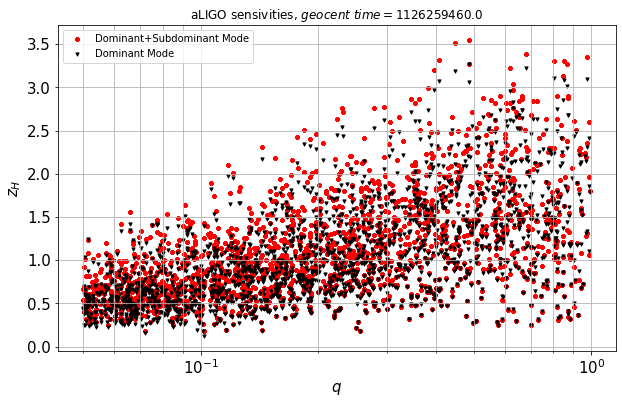

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(q_arr[snr_th_idx], DZ_arr[snr_th_idx], s=10, label='Dominant+Subdominant Mode', c='r', marker='P')
plt.scatter(q_arr[snr_th_idx], DZ_arrn[snr_th_idx], s=10, label='Dominant Mode', c='black', marker = 'v')
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$z_{H}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="best")
plt.grid(which="both")
plt.xscale("log")
plt.title("aLIGO sensivities, $geocent\ time =1126259460.0.$")
plt.savefig("Dominant-Subdominant_Mode.pdf")

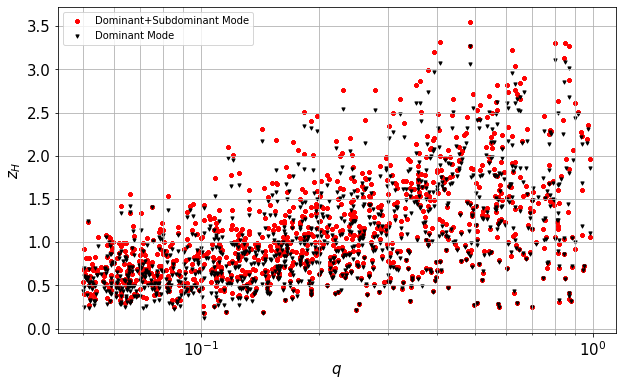

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(q_arr[snr_th_idx][:1000], DZ_arr[snr_th_idx][:1000], s=10, label='Dominant+Subdominant Mode', c='r', marker='P')
plt.scatter(q_arr[snr_th_idx][:1000], DZ_arrn[snr_th_idx][:1000], s=10, label='Dominant Mode', c='black', marker = 'v')
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$z_{H}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="best")
plt.grid(which="both")
plt.xscale("log")

In [56]:
idx = np.where(rho_tot_arr >= 8)[0]

In [57]:
len(idx)

1905

In [58]:
len(q_arr[snr_th_idx])

1905

In [80]:
DZ_arr = pd.DataFrame(DZ_arr)
print(DZ_arr[snr_th_idx].max())

0    3.55007
dtype: float64


In [81]:
print(DZ_arr[snr_th_idx].min())

0    0.182709
dtype: float64


In [82]:
factor = 3.55007/0.18270
factor

19.431143951833604

In [4]:
data = pd.read_csv("/home/aruna/Downloads/ICTS-TIFR/scripts/injections/injection.dat",sep=" ")

In [5]:
data

,mass_1,mass_2,dec,ra,cos_theta_jn,psi,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,luminosity_distance,geocent_time
0,465.712025,329.173827,-1.196860,5.798143,0.576316,2.284787,2.175446,0.845812,0.533134,0.0,0.0,0.0,0.0,15283.752947,1.126259e+09
1,476.495134,438.097396,0.203643,3.723665,-0.867927,3.126488,2.047074,0.845270,0.431523,0.0,0.0,0.0,0.0,9267.934099,1.126259e+09
2,139.100439,131.871450,-0.632144,3.444762,0.692528,3.057487,2.568289,0.562724,0.520630,0.0,0.0,0.0,0.0,25686.674451,1.126259e+09
3,79.325260,65.887046,-0.926376,0.716933,0.488185,1.124932,0.404667,0.598372,0.865740,0.0,0.0,0.0,0.0,13195.441363,1.126259e+09
4,322.133161,285.838784,-0.486233,1.548915,0.806643,0.429909,5.431293,0.155853,0.440893,0.0,0.0,0.0,0.0,11943.144586,1.126259e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,412.689308,82.081769,1.009255,0.205546,0.301508,2.452014,1.408463,0.618301,0.967595,0.0,0.0,0.0,0.0,5945.664576,1.126259e+09
19996,330.466172,58.486139,0.244604,6.167412,0.412427,0.696456,3.980104,0.223056,0.348002,0.0,0.0,0.0,0.0,25971.684230,1.126259e+09
19997,360.774159,163.063564,-0.752102,5.045918,-0.856610,1.837099,1.880430,0.754730,0.848376,0.0,0.0,0.0,0.0,26890.976829,1.126259e+09
19998,448.652960,210.387990,-0.724486,3.304149,-0.805738,2.046135,1.723032,0.793085,0.095075,0.0,0.0,0.0,0.0,12836.504310,1.126259e+09


In [5]:
snr_th = 8
geocent_time = 1126259460.0
m2_arr = []
m1_arr = []
q_arr = []
s1z_arr = []
s2z_arr = []
luminosity_distance_arr = []
#SNR
rho_tot_arr = []
DH_arr = []
DZ_arr = []
rho1_arr = []
rho2_arr = []
rho3_arr = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")


# # call the psd and antenna patterns outside the for loop

for m1, m2, dec, ra, cos_theta, psi, s1z, s2z, luminosity_distance in zip(data["mass_1"], data["mass_2"], data["dec"], data["ra"], data["cos_theta_jn"], data["psi"], data["a_1"], data["a_2"], data["luminosity_distance"]):
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    #functions require the values of mass1 and mass2
    q = m2/m1
    m2_arr.append(m2)
    m1_arr.append(m1)
    q_arr.append(q)
    s1z_arr.append(s1z)
    s2z_arr.append(s2z)
    luminosity_distance_arr.append(luminosity_distance)
    #print("luminosity_distance = %f"%(luminosity_distance))
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z=s1z,  
                               psi=psi,
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance)
    
    #Antenna patterns
    fp1, fc1 = d1.antenna_pattern(ra, dec, psi, geocent_time)
    fp2, fc2 = d2.antenna_pattern(ra, dec, psi, geocent_time)
    fp3, fc3 = d3.antenna_pattern(ra, dec, psi, geocent_time)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1 = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2 = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3 = np.trapz(snr_sq_integrand3, f_arr1)
    rho1 = np.sqrt(rho_sq1)
    rho2 = np.sqrt(rho_sq2)
    rho3 = np.sqrt(rho_sq3)
    rho_tot = np.sqrt(rho_sq1+rho_sq2+rho_sq3)
    rho_tot_arr.append(rho_tot)
    d=(rho_tot*luminosity_distance/snr_th)
    DZ_arr.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, d*units.Mpc))
    rho1_arr.append(rho1)
    rho2_arr.append(rho2)
    rho3_arr.append(rho3)
    # save the snr for every detector here

KeyboardInterrupt: 

In [19]:
DZ_arr=np.array(DZ_arr)
DZ_arrn=np.array(DZ_arrn)
rho_tot_arr = np.array(rho_tot_arr)
q_arr = np.array(q_arr)
luminosity_distance_arr = np.array(luminosity_distance_arr)
snr_th_idx = rho_tot_arr >= 8

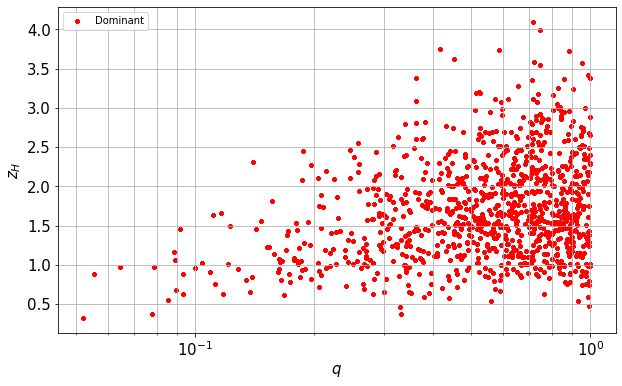

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(q_arr[snr_th_idx][:1000], DZ_arr[snr_th_idx][:1000], s=10, label='Dominant', c='r', marker='P')
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$z_{H}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="best")
plt.grid(which="both")
plt.xscale("log")

In [18]:
snr_th = 8
geocent_time = 1126259460.0
m2_arr = []
m1_arr = []
q_arr = []
s1z_arr = []
s2z_arr = []
luminosity_distance_arr = []
#SNR
rho_tot_arrn = []
DH_arrn = []
DZ_arrn = []
rho1_arrn = []
rho2_arrn = []
rho3_arrn = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")


# # call the psd and antenna patterns outside the for loop

for m1, m2, dec, ra, cos_theta, psi, s1z, s2z, luminosity_distance in zip(data["mass_1"], data["mass_2"], data["dec"], data["ra"], data["cos_theta_jn"], data["psi"], data["a_1"], data["a_2"], data["luminosity_distance"]):
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    #functions require the values of mass1 and mass2
    q = m2/m1
    m2_arr.append(m2)
    m1_arr.append(m1)
    q_arr.append(q)
    s1z_arr.append(s1z)
    s2z_arr.append(s2z)
    luminosity_distance_arr.append(luminosity_distance)
    #print("luminosity_distance = %f"%(luminosity_distance))
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z=s1z,  
                               psi=psi,
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance,
                              mode_array=[[2,2],[2, -2]])
    
    #Antenna patterns
    fp1, fc1 = d1.antenna_pattern(ra, dec, psi, geocent_time)
    fp2, fc2 = d2.antenna_pattern(ra, dec, psi, geocent_time)
    fp3, fc3 = d3.antenna_pattern(ra, dec, psi, geocent_time)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1n = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2n = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3n = np.trapz(snr_sq_integrand3, f_arr1)
    rho1n = np.sqrt(rho_sq1n)
    rho2n = np.sqrt(rho_sq2n)
    rho3n = np.sqrt(rho_sq3n)
    rho_totn = np.sqrt(rho_sq1n+rho_sq2n+rho_sq3n)
    rho_tot_arrn.append(rho_totn)
    dn=(rho_totn*luminosity_distance/snr_th)
    DZ_arrn.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, dn*units.Mpc))
    rho1_arrn.append(rho1n)
    rho2_arrn.append(rho2n)
    rho3_arrn.append(rho3n)
    # save the snr for every detector here

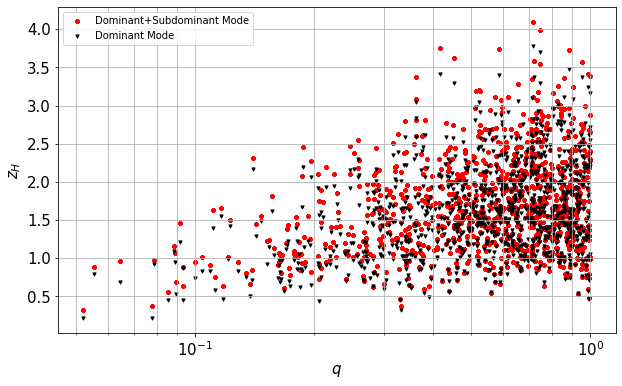

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(q_arr[snr_th_idx][:1000], DZ_arr[snr_th_idx][:1000], s=10, label='Dominant+Subdominant Mode', c='r', marker='P')
plt.scatter(q_arr[snr_th_idx][:1000], DZ_arrn[snr_th_idx][:1000], s=10, label='Dominant Mode', c='black', marker = 'v')
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$z_{H}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="best")
plt.grid(which="both")
plt.xscale("log")
plt.savefig("Sample_m1_and_m2_from_uniform_distributions.pdf")

In [20]:
A=DZ_arr[snr_th_idx]/DZ_arrn[snr_th_idx]
df=pd.DataFrame(A)
df.to_csv("Relative_Redshift_of_Domimant_Mode_to_Higher_Mode.dat",index=False)

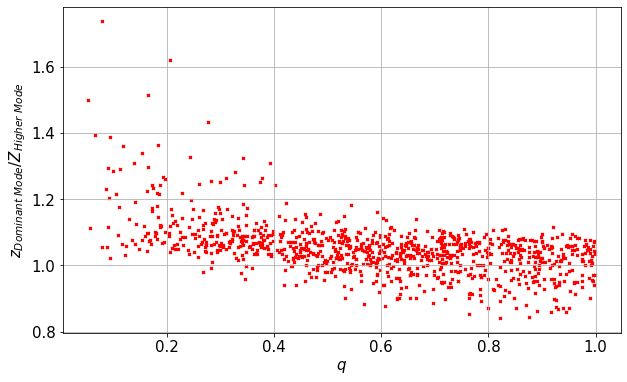

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(q_arr[snr_th_idx][:1000], A[snr_th_idx][:1000], s=8, c='r', marker='x')
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$Z_H^{22}/z_H^{HM+22}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(which="both")
#plt.yscale("log")
plt.savefig("Mass_Ratio(q)_vs_Relative_redshift_distance.png")

# Matched Filter

In [9]:
snr_th = 8
geocent_time = 1126259460.0
m2_arr = []
m1_arr = []
q_arr = []
s1z_arr = []
s2z_arr = []
luminosity_distance_arr = []
#SNR
rho_tot_arr = []
DH_arr = []
DZ_arr = []
rho1_arr = []
rho2_arr = []
rho3_arr = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")


# # call the psd and antenna patterns outside the for loop

for m1, m2, dec, ra, cos_theta, psi, s1z, s2z, luminosity_distance in zip(data["mass_1"], data["mass_2"], data["dec"], data["ra"], data["cos_theta_jn"], data["psi"], data["a_1"], data["a_2"], data["luminosity_distance"]):
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    #functions require the values of mass1 and mass2
    q = m2/m1
    m2_arr.append(m2)
    m1_arr.append(m1)
    q_arr.append(q)
    s1z_arr.append(s1z)
    s2z_arr.append(s2z)
    luminosity_distance_arr.append(luminosity_distance)
    #print("luminosity_distance = %f"%(luminosity_distance))
    # call the waveform "get_fd_waveform"
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z=s1z,  
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance)
    
    #Antenna patterns
    fp1, fc1 = d1.antenna_pattern(ra, dec, psi, geocent_time)
    fp2, fc2 = d2.antenna_pattern(ra, dec, psi, geocent_time)
    fp3, fc3 = d3.antenna_pattern(ra, dec, psi, geocent_time)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    hf1_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf1))
    hf2_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf2))
    hf3_interp = interpolate.interp1d(hp1.sample_frequencies.data, abs(hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * abs(hf1_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * abs(hf2_interp(f_arr1))**2 / sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * abs(hf3_interp(f_arr1))**2 / sf_interp(f_arr1)
    # compute the integral
    rho_sq1 = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2 = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3 = np.trapz(snr_sq_integrand3, f_arr1)
    rho1 = np.sqrt(rho_sq1)
    rho2 = np.sqrt(rho_sq2)
    rho3 = np.sqrt(rho_sq3)
    rho_tot = np.sqrt(rho_sq1+rho_sq2+rho_sq3)
    rho_tot_arr.append(rho_tot)
    d=(rho_tot*luminosity_distance/snr_th)
    DZ_arr.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, d*units.Mpc))
    rho1_arr.append(rho1)
    rho2_arr.append(rho2)
    rho3_arr.append(rho3)
    # save the snr for every detector here

In [6]:
snr_th = 8
geocent_time = 1126259460.0
m2_arr = []
m1_arr = []
q_arr = []
s1z_arr = []
s2z_arr = []
luminosity_distance_arr = []
#SNR
rho_tot_arrn = []
DH_arrn = []
DZ_arrn = []
rho1_arrn = []
rho2_arrn = []
rho3_arrn = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")


# # call the psd and antenna patterns outside the for loop

for m1, m2, dec, ra, cos_theta, psi, s1z, s2z, luminosity_distance in zip(data["mass_1"], data["mass_2"], data["dec"], data["ra"], data["cos_theta_jn"], data["psi"], data["a_1"], data["a_2"], data["luminosity_distance"]):
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    #functions require the values of mass1 and mass2
    q = m2/m1
    m2_arr.append(m2)
    m1_arr.append(m1)
    q_arr.append(q)
    s1z_arr.append(s1z)
    s2z_arr.append(s2z)
    luminosity_distance_arr.append(luminosity_distance)
    #print("luminosity_distance = %f"%(luminosity_distance))
    # call the waveform "get_fd_waveform"
    #The first waveform
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXPHM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z=s1z,  
                               psi=psi,
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance)
    #THe second waveform
    hp1n, hc1n = get_fd_waveform(approximant="IMRPhenomXP",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01,spin1z=s1z,  
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance)
    
    #Antenna patterns
    fp1, fc1 = d1.antenna_pattern(ra, dec, psi, geocent_time)
    fp2, fc2 = d2.antenna_pattern(ra, dec, psi, geocent_time)
    fp3, fc3 = d3.antenna_pattern(ra, dec, psi, geocent_time)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    #The polarisation corresponding to the second waveform
    hf1n = fp1 * hp1n.data + fc1 * hc1n.data
    hf2n = fp2 * hp1n.data + fc2 * hc1n.data
    hf3n = fp3 * hp1n.data + fc3 * hc1n.data
    

    hf1_interpn = interpolate.interp1d(hp1.sample_frequencies.data, np.real(np.conjugate(hf1n)*hf1))
    hf2_interpn = interpolate.interp1d(hp1.sample_frequencies.data, np.real(np.conjugate(hf2n)*hf2))
    hf3_interpn = interpolate.interp1d(hp1.sample_frequencies.data, np.real(np.conjugate(hf3n)*hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * hf1_interpn(f_arr1)/ sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * hf2_interpn(f_arr1)/ sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * hf3_interpn(f_arr1)/ sf_interp(f_arr1)
    # compute the integral
    rho_sq1n = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2n = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3n = np.trapz(snr_sq_integrand3, f_arr1)
    rho1n = np.sqrt(rho_sq1n)
    rho2n = np.sqrt(rho_sq2n)
    rho3n = np.sqrt(rho_sq3n)
    rho_totn = np.sqrt(rho_sq1n+rho_sq2n+rho_sq3n)
    rho_tot_arrn.append(rho_totn)
    dn=(rho_totn*luminosity_distance/snr_th)
    DZ_arrn.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, dn*units.Mpc))
    rho1_arrn.append(rho1n)
    rho2_arrn.append(rho2n)
    rho3_arrn.append(rho3n)

KeyboardInterrupt: 

In [ ]:
DZ_arrn=np.array(DZ_arrn)
DZ_arr = np.array(DZ_arr)
rho_tot_arrn = np.array(rho_tot_arrn)
q_arr = np.array(q_arr)
luminosity_distance_arr = np.array(luminosity_distance_arr)
snr_th_idx = rho_tot_arrn >= 8

In [ ]:
B = DZ_arr/DZ_arrn
df=pd.DataFrame(B)
df.to_csv("XPHM_and_XP_Mode.dat",index=False)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(q_arr[snr_th_idx][:1000], B[snr_th_idx][:1000], s=10, c='blue', marker = 'X')
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$Z_H^{22}/z_H^{HM+22}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale("log")
plt.grid(which="both")


In [6]:
snr_th = 8
geocent_time = 1126259460.0
m2_arr = []
m1_arr = []
q_arr = []
s1z_arr = []
s2z_arr = []
luminosity_distance_arr = []
#SNR
rho_tot_arrn = []
DH_arrn = []
DZ_arrn = []
rho1_arrn = []
rho2_arrn = []
rho3_arrn = []
d1 = Detector("H1")
d2 = Detector("L1")
d3 = Detector("V1")


# # call the psd and antenna patterns outside the for loop

for m1, m2, dec, ra, cos_theta, psi, s1z, s2z, luminosity_distance in zip(data["mass_1"], data["mass_2"], data["dec"], data["ra"], data["cos_theta_jn"], data["psi"], data["a_1"], data["a_2"], data["luminosity_distance"]):
    #from chirp-mass and symmetric mass ratio find out
    #the values of mass1 and mass2 because the waveform 
    #functions require the values of mass1 and mass2
    q = m2/m1
    m2_arr.append(m2)
    m1_arr.append(m1)
    q_arr.append(q)
    s1z_arr.append(s1z)
    s2z_arr.append(s2z)
    luminosity_distance_arr.append(luminosity_distance)
    #print("luminosity_distance = %f"%(luminosity_distance))
    # call the waveform "get_fd_waveform"
    #The first waveform
    hp1, hc1 = get_fd_waveform(approximant="IMRPhenomXP",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01, spin1z=s1z,
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance)
    #The second waveform
    hp1n, hc1n = get_fd_waveform(approximant="SEOBNRv4HM_ROM",
                         mass1=m1, mass2=m2,
                          f_lower=10, delta_f=0.01, spin1z=s1z,  
                               spin2z=s2z, 
                               f_final=1024,
                            inclination=np.arccos(cos_theta),
                            distance=luminosity_distance)
    
    #Antenna patterns
    fp1, fc1 = d1.antenna_pattern(ra, dec, psi, geocent_time)
    fp2, fc2 = d2.antenna_pattern(ra, dec, psi, geocent_time)
    fp3, fc3 = d3.antenna_pattern(ra, dec, psi, geocent_time)
    
    #combine the "+" and "*" polarisations
    hf1 = fp1 * hp1.data + fc1 * hc1.data
    hf2 = fp2 * hp1.data + fc2 * hc1.data
    hf3 = fp3 * hp1.data + fc3 * hc1.data
    
    #The polarisation corresponding to the second waveform
    hf1n = fp1 * hp1n.data + fc1 * hc1n.data
    hf2n = fp2 * hp1n.data + fc2 * hc1n.data
    hf3n = fp3 * hp1n.data + fc3 * hc1n.data
    

    hf1_interpn = interpolate.interp1d(hp1.sample_frequencies.data, np.real(np.conjugate(hf1n)*hf1))
    hf2_interpn = interpolate.interp1d(hp1.sample_frequencies.data, np.real(np.conjugate(hf2n)*hf2))
    hf3_interpn = interpolate.interp1d(hp1.sample_frequencies.data, np.real(np.conjugate(hf3n)*hf3))
    #compute the integrand for SNR
    f_arr1 = np.linspace(20, max(hp1.sample_frequencies.data), 20000)
    
    snr_sq_integrand1 = 4 * hf1_interpn(f_arr1)/sf_interp(f_arr1)
    snr_sq_integrand2 = 4 * hf2_interpn(f_arr1)/sf_interp(f_arr1)
    snr_sq_integrand3 = 4 * hf3_interpn(f_arr1)/sf_interp(f_arr1)
    # compute the integral
    rho_sq1n = np.trapz(snr_sq_integrand1, f_arr1)
    rho_sq2n = np.trapz(snr_sq_integrand2, f_arr1)
    rho_sq3n = np.trapz(snr_sq_integrand3, f_arr1)
    rho1n = np.sqrt(rho_sq1n)
    rho2n = np.sqrt(rho_sq2n)
    rho3n = np.sqrt(rho_sq3n)
    rho_totn = np.sqrt(rho_sq1n+rho_sq2n+rho_sq3n)
    rho_tot_arrn.append(rho_totn)
    dn=(rho_totn*luminosity_distance/snr_th)
    DZ_arrn.append(cosmo.z_at_value(cosmo.Planck15.luminosity_distance, dn*units.Mpc))
    rho1_arrn.append(rho1n)
    rho2_arrn.append(rho2n)
    rho3_arrn.append(rho3n)

RuntimeError: Internal function call failed: Generic failure

In [11]:
q_arr=np.array(q_arr)
DZ_arrn = np.array(DZ_arrn)
DZ_arrn = np.array(DZ_arrn)
rho_tot_arrn = np.array(rho_tot_arrn)
luminosity_distance_arr = np.array(luminosity_distance_arr)
snr_th_idx = rho_tot_arrn >= 8

In [12]:
C=DZ_arr/DZ_arrn
df=pd.DataFrame(C)
df.to_csv("XP_and_Pv3_Mode.dat",index=False)

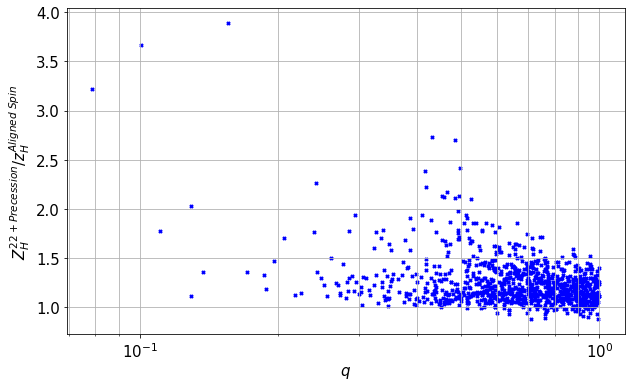

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(q_arr[snr_th_idx][:1000], C[snr_th_idx][:1000], s=10, c='blue', marker = 'X')
plt.xlabel(r"$q$", fontsize=15)
plt.ylabel(r"$Z_H^{22+Precession}/z_H^{Aligned\ Spin}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale("log")
plt.grid(which="both")

In [8]:
fd_approximants()

['EccentricFD',
 'TaylorF2',
 'TaylorF2Ecc',
 'TaylorF2NLTides',
 'TaylorF2RedSpin',
 'TaylorF2RedSpinTidal',
 'SpinTaylorF2',
 'EOBNRv2_ROM',
 'EOBNRv2HM_ROM',
 'SEOBNRv1_ROM_EffectiveSpin',
 'SEOBNRv1_ROM_DoubleSpin',
 'SEOBNRv2_ROM_EffectiveSpin',
 'SEOBNRv2_ROM_DoubleSpin',
 'SEOBNRv2_ROM_DoubleSpin_HI',
 'Lackey_Tidal_2013_SEOBNRv2_ROM',
 'SEOBNRv4_ROM',
 'SEOBNRv4HM_ROM',
 'SEOBNRv4_ROM_NRTidal',
 'SEOBNRv4_ROM_NRTidalv2',
 'SEOBNRv4_ROM_NRTidalv2_NSBH',
 'SEOBNRv4T_surrogate',
 'IMRPhenomA',
 'IMRPhenomB',
 'IMRPhenomC',
 'IMRPhenomD',
 'IMRPhenomD_NRTidal',
 'IMRPhenomD_NRTidalv2',
 'IMRPhenomNSBH',
 'IMRPhenomHM',
 'IMRPhenomP',
 'IMRPhenomPv2',
 'IMRPhenomPv2_NRTidal',
 'IMRPhenomPv2_NRTidalv2',
 'SpinTaylorT4Fourier',
 'SpinTaylorT5Fourier',
 'NRSur4d2s',
 'IMRPhenomXAS',
 'IMRPhenomXHM',
 'IMRPhenomPv3',
 'IMRPhenomPv3HM',
 'IMRPhenomXP',
 'IMRPhenomXPHM',
 'SpinTaylorF2_SWAPPER',
 'TaylorF2NL',
 'PreTaylorF2',
 'multiband',
 'TaylorF2_INTERP',
 'SpinTaylorT5',
 'SEOBNRv1_R

In [27]:
get_fd_waveform?